Dataset

The train dataset is in the file called data.csv. These are the prices for the day ahead hourly market.
Schema: <br>
● settlement_period: start of the settlement period in local UK time zone (no need to worry about
DST start/end) <br>
● forecast_wind_mw: day ahead forecasts for wind in MW. The settlement period it is indexed
against is for the forecasted period. You can assume you have this information from the day
before <br>
● national_demand_mw: observation of national demand in MW for the given settlement period <br>
● embedded_solar_generation_mw: observation of generation of solar energy in MW <br>
● price_gbo: the price we want to predict in GBP 

The dataset has an hourly resolution, and the forecast we want to make available to the team is a day ahead forecast, i.e. each day we need to predict the prices for the next 24 hours (looking ahead).


Executing Summary:

Data cleaning. Forecast_wind_mw has 4 days of misssing values (06/10/2019 23:00, 07/10/2019 00:00-22:00, 02/02/2020 00:00-23:00, 03/02/2020 00:00-23:00, 28/02/2021 00:00-23:00) I replaced by median for the corresponding hour using previous dates. 
Forecast_wind_mw has three outliers that I replaced by median as well: <br>
18/07/2019 02:00,  999999  <br>
12/09/2019 01:00, -999999  <br>
13/11/2019 09:00,  999999  <br>
national_demand_mw has outlier at 21/09/2019  06:00:00, it has value -999999. We replace it by median. <br>

We have negative prices but we were told it is fine. The high prices in Jan 2021 are explained in https://auroraer.com/insight/gb-wholesale-market-summary-january-2021/  <br>

We have created the following features. For the previous values of "forecast_wind_mw", "national_demand_mw", "embedded_solar_generation_mw" and "price_gbp" given hour we computed statistics "median", "std", "Q25", "Q75", "max" and  "ORDER" (order define the lag). We also use features such as season (winter, spring, summer and autumn) and hour (0-23).

We use the following time interval for train, validation and test datasets: <br>
1) train, 2019-07-10 00:00:00 - 2020-09-17 18:00:00; <br>
2) validation, 2020-09-17 19:00:00  2021-02-07 08:00:00; <br>
3) test, 2021-02-07 09:00:0  2021-06-29 23:00:00. <br>

We use three models: 1) we use the entire training dataset to make one model (let us denote it as GP ALL, see Fig. 1 and Table 1); 2) We use Gaussian Processes in autoregressive manner using 5 previous prices, one model per hour, we denote it as GP SW (see Fig. 2 and Table 1);; 3) Facebook Prophet using only timestamp and price values (see Fig. 3); 4) Facebook Prophet with extra inputs (covariates) selected by forward feature selection algorithm using Mean Relative Absolute Error (MRAE), selected featues: ['season', 'Hour', 'forecast_wind_mw_ORDER_4', 'forecast_wind_mw_std']  (see Fig. 4); 5) Facebook Prophet that uses all features  (see Fig. 5).  

It seems GP SW perform better than GP ALL but we have not optimise it performance using different features, kernels and etc.

The Prophet procedure is an additive regression model with four main components — a piecewise linear logistic growth curve trend; a yearly seasonal component modelled using Fourier series; a weekly seasonal component created using dummy variables; a user-provided list of important holidays. We did not use Bank holidays in our model but it is really easy to update the model with this functionality.

The best model in MRAE sense obtained by forward feature selection algorithm (see the following performance table). <br>

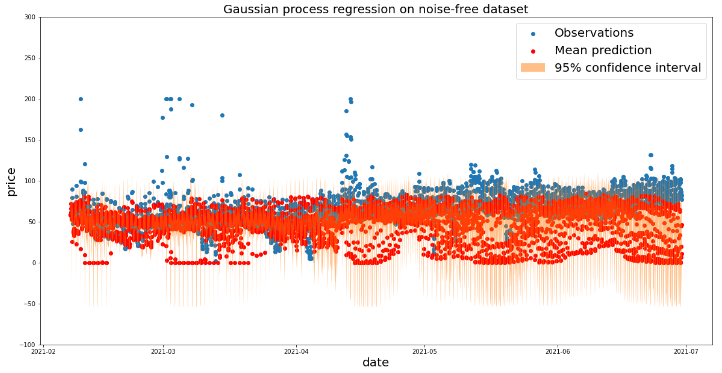
Fig. 1 Illustration of performance for GP ALL using test dataset.

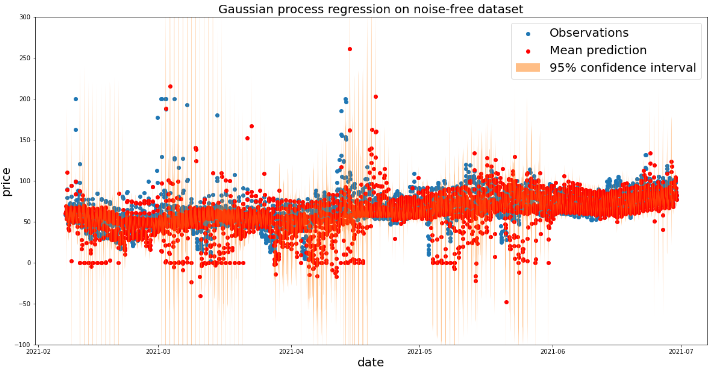
Fig. 2 Illustration of performance for GP SW using test dataset.

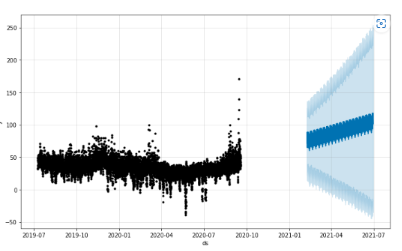
Fig. 3 Illustration of forecast by FP N1 model, black dots are training dataset and blue ones are test dataset prediction.


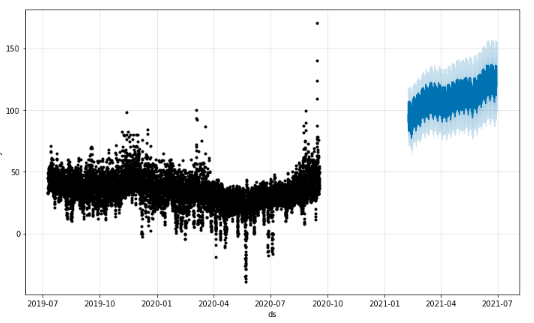
Fig. 4 Illustration of forecast by FP N2 model, black dots are training dataset and blue ones are test dataset prediction.

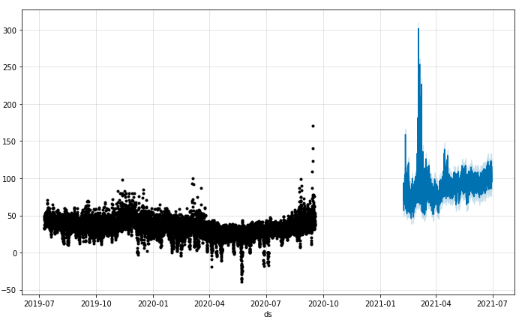

Fig. 5 Illustration of forecast by FP N3 model, black dots are training dataset and blue ones are test dataset prediction.

Table 1 Performance of GPs
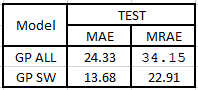

Table 2 Performance of Facebook Prophet <br>
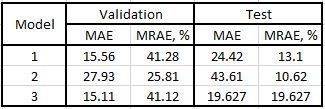

### Future work: <br>

At the moment I training dataset fixed but we can use it in sliding window fashion - we will use all data that are availble before making the prediction to train the model.

We can use the forecast of "national_demand_mw" and "embedded_solar_generation_mw" as features obtained by other models.
Hyperparameters Facebook Prophet can be selected using validation dataset.

We can use transformer for forecast: https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e <br> or Bayesian LSTM https://colab.research.google.com/github/PawaritL/BayesianLSTM/blob/master/Energy_Consumption_Predictions_with_Bayesian_LSTMs_in_PyTorch.ipynb#scrollTo=3FQQioKQ-Tkr







In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [3]:
import os
from time import time
import warnings
warnings.filterwarnings("ignore")
#
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [39]:
import matplotlib
import statsmodels
import prophet
import sklearn
print("matplotlib.__version__: ", matplotlib.__version__)
print("pd.__version__: ", pd.__version__)
print("np.__version__: ", np.__version__)
print("sns.__version__: ", sns.__version__)
print("statsmodels.__version__: ", statsmodels.__version__)
print("prophet.__version__: ", prophet.__version__)
print("sklearn.__version__: ", sklearn.__version__)

matplotlib.__version__:  3.5.2
pd.__version__:  1.4.4
np.__version__:  1.21.5
sns.__version__:  0.11.2
statsmodels.__version__:  0.13.2
prophet.__version__:  1.1.4
sklearn.__version__:  1.0.2


In [5]:
# Plot distribution of features for every group or class defined by variable "groupby" (see below)
# slices_values are feature under consideretion
def compare_variables(df, slice_values, groupby='y', title = "", order = []):
    
    for gl in slice_values:
        fig, ax = plt.subplots(1,2,figsize=[15,5])
        if len(order) > 0:
           sns.violinplot(x=groupby, y=gl, data=df, order = order, height = 5, aspect = 1.7, ax = ax[0]).set_title(title)
        else:
           sns.violinplot(x=groupby, y=gl, data=df,                height = 5, aspect = 1.7, ax = ax[0]).set_title(title) 
        #
        groups = df.groupby(groupby)
        for t in df[groupby].unique():
            dftmp = groups.get_group(t)
            try:
               sns.kdeplot(dftmp[gl], ax = ax[1], shade = True, label = t).set_title(title)
            except Exception as e:
               print("Exception: ", str(e))
        #
        ax[1].set_xlabel(gl)
        ax[1].legend(title = groupby)
        #ax[1].set_xlim(xlim[0], xlim[1])
        ax[0].grid()
    plt.show()
    return plt

In [6]:
#Perform Dickey-Fuller test:
# H0: The time series is non-stationary. 
# In other words, it has some time-dependent structure and does not have constant variance over time.
# HA: The time series is stationary.
#
# plot rolling mean and std.
def test_stationarity(df, difference = "Y", col = "price_gbp", window = 11, center = True):
    if difference == "N":
       timeseries = df[col]
    else:
       timeseries = df
    #
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = window, center = center).apply(lambda x: np.mean(x)) 
    rolstd  = timeseries.rolling(window = window, center = center).apply(lambda x: np.std(x))
    #
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    if difference == "N":
       orig = plt.plot(df["Date"], timeseries, color = 'blue',  label = 'Original')
       mean = plt.plot(df["Date"], rolmean,    color = 'red',   label = 'Rolling Mean')
       std  = plt.plot(df["Date"], rolstd,     color = 'black', label = 'Rolling Std')
    else:
       orig = plt.plot(timeseries, color = 'blue',  label = 'Original')
       mean = plt.plot(rolmean,    color = 'red',   label = 'Rolling Mean')
       std  = plt.plot(rolstd,     color = 'black', label = 'Rolling Std')   
    #    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [7]:
# remove outliers
dd = pd.DataFrame({"n": range(21)})
def remove_large_value(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    #
    last = df.values[-1]
    #
    if (last < (Q1 - 1.5 * IQR)) | (last > (Q3 + 1.5 * IQR)):
       last = np.median(df.values)
    #
    return last
# test how it works
dd["last"] = dd["n"].rolling(window=5, center=False).apply(lambda x: remove_large_value(x))
dd

n  last
0    0   NaN
1    1   NaN
2    2   NaN
3    3   NaN
4    4   4.0
5    5   5.0
6    6   6.0
7    7   7.0
8    8   8.0
9    9   9.0
10  10  10.0
11  11  11.0
12  12  12.0
13  13  13.0
14  14  14.0
15  15  15.0
16  16  16.0
17  17  17.0
18  18  18.0
19  19  19.0
20  20  20.0

In [8]:
# 0 - Winter, 1 Spring etc.
def get_season(x):
    if   x in [12, 1, 2]:
         season = 0
    elif x in [3, 4, 5]:
         season = 1
    elif x in [6, 7, 8]:
         season = 2
    elif x in [9, 10, 11]:
         season = 3        
    return season

In [9]:
# We compute Mean Absolute Error and Mean Relative Absolute Error, %.
def preformance(m, data):
    fcst = m.predict(data)
    pred = fcst.merge(data[["ds", "y"]], on = "ds")
    #
    pred["MAE" ] = pred.apply(lambda x: np.abs(x["yhat"] -x["y"]), axis = 1)
    pred["MRAE"] = pred["yhat"] - pred["y"] * 100 / pred["y"]
    pred["MRAE"] = pred["MRAE"].apply(lambda x: np.abs(x))
    #
    MAE  = pred["MAE" ].mean()
    MRAE = pred["MRAE"].mean()
    #
    return MAE, MRAE

In [10]:
def replace_missing_values(x, values = [-999999, 999999]):
    dd = x.values[::24]
    #print("dd: ", dd)
    last_value = x.values[-1]
    #
    if last_value in values:
       value = np.nanmedian(dd)
    else:
       value = dd[-1] 
    #
    return value

In [11]:
df = pd.read_csv("data.csv")
df.describe()

forecast_wind_mw  national_demand_mw  embedded_solar_generation_mw  \
count      17472.000000        17568.000000                  17568.000000   
mean        5733.860062        28097.403575                   1346.136100   
std        13562.854070        14508.180308                   2092.550166   
min      -999999.000000      -999999.000000                      0.000000   
25%         2555.000000        22947.000000                      0.000000   
50%         5022.500000        27262.000000                     10.000000   
75%         8411.500000        32445.250000                   2170.000000   
max       999999.000000       999999.000000                   9680.000000   

          price_gbp  
count  17568.000000  
mean      44.363583  
std       29.551848  
min      -38.800000  
25%       30.900000  
50%       40.000000  
75%       53.760000  
max     1500.000000

# Explonatory Analysis

We check missing values, outliers and relationship between prices and other features.

In [12]:
dataset =  df.copy()
#
Datetime = "settlement_period"
#
dataset["ds"    ] = pd.to_datetime(df[Datetime])
dataset["Month" ] = pd.to_datetime(df[Datetime]).dt.month
dataset["Year"  ] = pd.to_datetime(df[Datetime]).dt.year
dataset["Date"  ] = pd.to_datetime(df[Datetime]).dt.date
dataset["Hour"  ] = pd.to_datetime(df[Datetime]).dt.hour
dataset["Week"  ] = pd.to_datetime(df[Datetime]).dt.week
dataset["Day"   ] = pd.to_datetime(df[Datetime]).dt.day_name()
dataset["season"] = dataset["Month"].apply(lambda x: get_season(x))
#
dataset.head()

settlement_period  forecast_wind_mw  national_demand_mw  \
0  2019-07-01 00:00:00            7939.0               18248   
1  2019-07-01 01:00:00            8130.0               17687   
2  2019-07-01 02:00:00            8238.0               17143   
3  2019-07-01 03:00:00            8365.0               17087   
4  2019-07-01 04:00:00            8497.0               17140   

   embedded_solar_generation_mw  price_gbp                  ds  Month  Year  \
0                             0      21.75 2019-07-01 00:00:00      7  2019   
1                             0      19.65 2019-07-01 01:00:00      7  2019   
2                             0      17.99 2019-07-01 02:00:00      7  2019   
3                             0      14.92 2019-07-01 03:00:00      7  2019   
4                            52      21.84 2019-07-01 04:00:00      7  2019   

         Date  Hour  Week     Day  season  
0  2019-07-01     0    27  Monday       2  
1  2019-07-01     1    27  Monday       2  
2  2019-07-01     2    27  Monday       2  
3  2019-07-01     3    27  Monday       2  
4  2019-07-01     4    27  Monday       2

In [13]:
# Count total NaN at each column in DataFrame, forecast_wind_mw has 96 missing values
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      dataset.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 settlement_period                0
forecast_wind_mw                96
national_demand_mw               0
embedded_solar_generation_mw     0
price_gbp                        0
ds                               0
Month                            0
Year                             0
Date                             0
Hour                             0
Week                             0
Day                              0
season                           0
dtype: int64


In [14]:
# remove missing values and outliers in forecast_wind_mw and national_demand_mw
window = 24 * 4 + 1 #
# replace missing values by median
dataset["forecast_wind_mw"] = dataset["forecast_wind_mw"].fillna(-999999)
dataset["forecast_wind_mw"] = dataset["forecast_wind_mw"].rolling(window = window, center=False).apply(lambda x: replace_missing_values(x))
#
# remove extreme values: -999999 and 999999
dataset["national_demand_mw"] = dataset["national_demand_mw"].rolling(window = window, center=False).apply(lambda x: replace_missing_values(x))
#
dataset = dataset[dataset["forecast_wind_mw"] != -999999].copy()
dataset = dataset.dropna()
dataset.describe()
#

forecast_wind_mw  national_demand_mw  embedded_solar_generation_mw  \
count      17472.000000        17472.000000                  17472.000000   
mean        5695.030907        28056.603136                   1338.970524   
std         3591.717288         6550.370433                   2085.765719   
min          378.000000        13367.000000                      0.000000   
25%         2563.000000        22947.000000                      0.000000   
50%         5051.000000        27259.000000                      9.000000   
75%         8443.000000        32466.750000                   2140.000000   
max        14138.000000        46433.000000                   9680.000000   

          price_gbp         Month          Year          Hour          Week  \
count  17472.000000  17472.000000  17472.000000  17472.000000  17472.000000   
mean      44.398505      6.509615   2020.001374     11.500000     26.723901   
std       29.623345      3.462601      0.704206      6.922385     15.253139   
min      -38.800000      1.000000   2019.000000      0.000000      1.000000   
25%       30.857500      3.750000   2020.000000      5.750000     13.000000   
50%       40.000000      6.500000   2020.000000     11.500000     27.000000   
75%       53.910000     10.000000   2020.000000     17.250000     40.000000   
max     1500.000000     12.000000   2021.000000     23.000000     53.000000   

             season  
count  17472.000000  
mean       1.497253  
std        1.118063  
min        0.000000  
25%        0.750000  
50%        1.000000  
75%        2.250000  
max        3.000000

In [15]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      dataset.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 settlement_period               0
forecast_wind_mw                0
national_demand_mw              0
embedded_solar_generation_mw    0
price_gbp                       0
ds                              0
Month                           0
Year                            0
Date                            0
Hour                            0
Week                            0
Day                             0
season                          0
dtype: int64


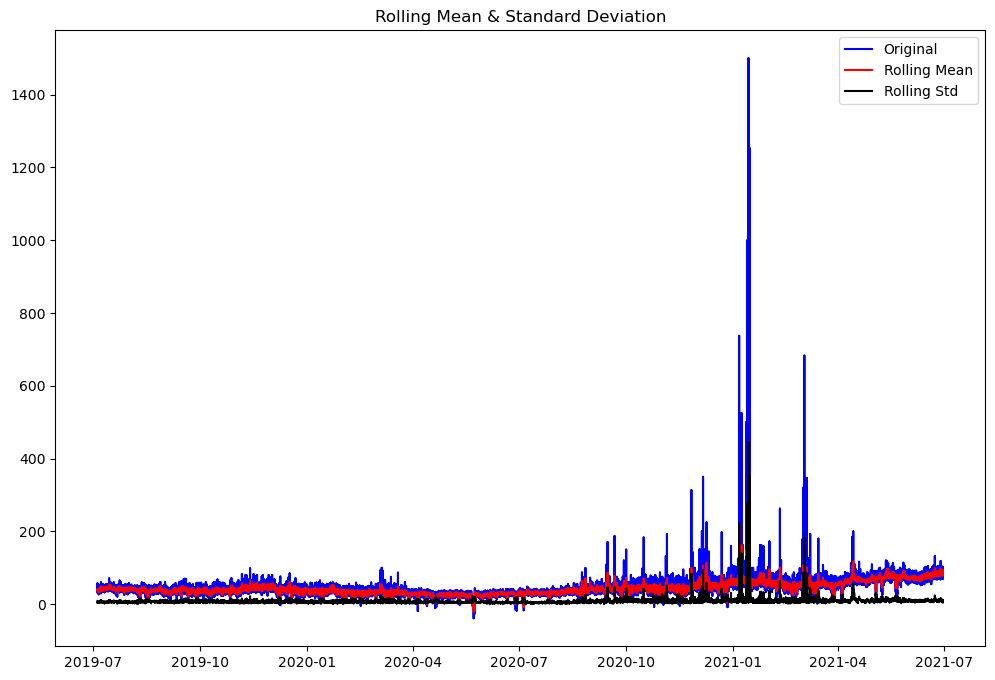

Results of Dickey-Fuller Test:
Test Statistic                -6.829237e+00
p-value                        1.912501e-09
#Lags Used                     3.200000e+01
Number of Observations Used    1.743900e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


In [16]:
# although we have large spikes of prices Dickey-Fuller Test tells that original data are stationary
# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. 
# It has some time dependent structure.
#
# Alternate Hypothesis (H1): The null hypothesis is rejected; 
# it suggests the time series does not have a unit root, meaning it is stationary. 
# It does not have time-dependent structure.
test_stationarity(dataset, difference = "N")

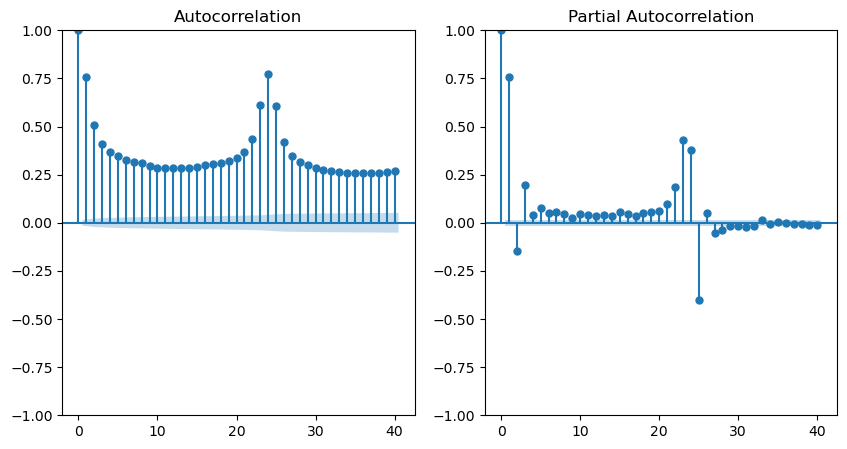

In [17]:
# We can cleary see that the prices kind of have similar patter every 24 hours.
# Autocorrelation has the second peak at around 24.
series = dataset["price_gbp"]
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf( dataset["price_gbp" ].values.squeeze(), lags=40, ax=ax[0])
plot_pacf(dataset["price_gbp" ].values.squeeze(), lags=40, ax=ax[1])
plt.show()

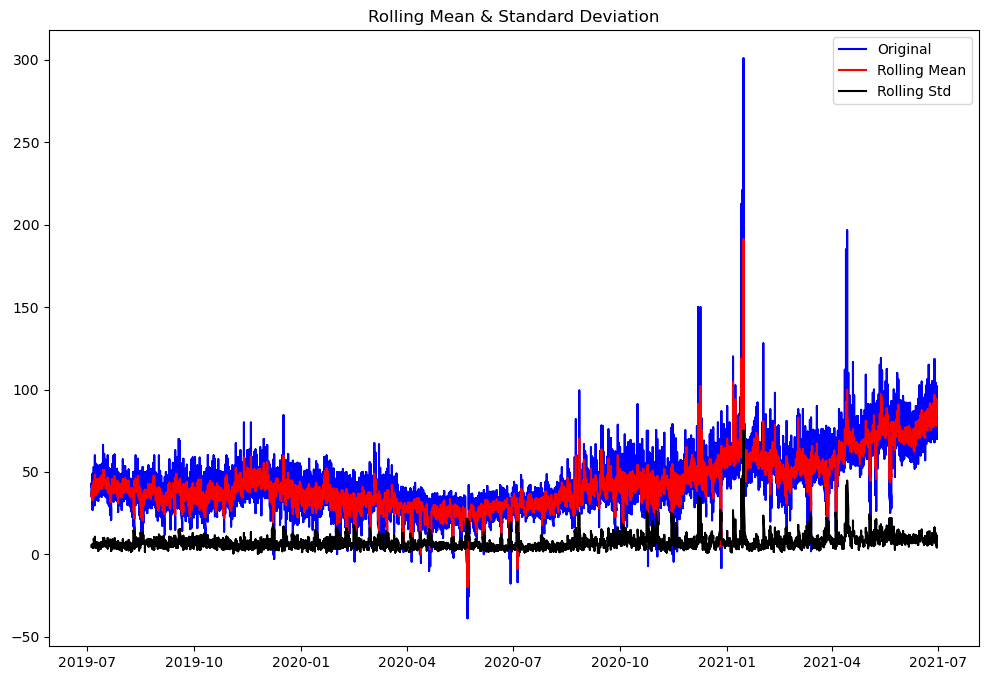

Results of Dickey-Fuller Test:
Test Statistic                    -4.222576
p-value                            0.000603
#Lags Used                        44.000000
Number of Observations Used    17411.000000
Critical Value (1%)               -3.430726
Critical Value (5%)               -2.861706
Critical Value (10%)              -2.566858
dtype: float64


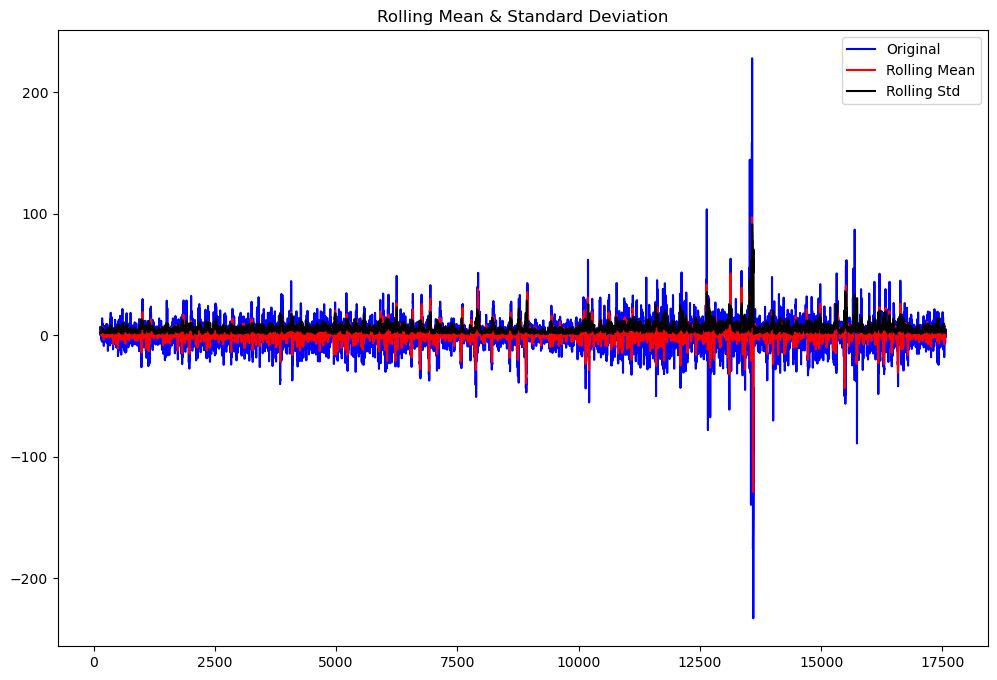

Results of Dickey-Fuller Test:
Test Statistic                   -22.728874
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17387.000000
Critical Value (1%)               -3.430726
Critical Value (5%)               -2.861706
Critical Value (10%)              -2.566858
dtype: float64


In [18]:
# we have outliers in prices
# We find difference between prices that are 24 hours apart.
dataset["processed_price_gbp"] = dataset["price_gbp"].rolling(window=17, center=False).apply(lambda x: remove_large_value(x))
#
dataset_drop_na = dataset.dropna()
test_stationarity(dataset_drop_na, difference = "N", col = "processed_price_gbp")
#
remove_season_series = dataset_drop_na
remove_season_series_diff = remove_season_series["processed_price_gbp"] - remove_season_series["processed_price_gbp"].shift(24)
remove_season_series_diff = remove_season_series_diff.dropna()
test_stationarity(remove_season_series_diff)

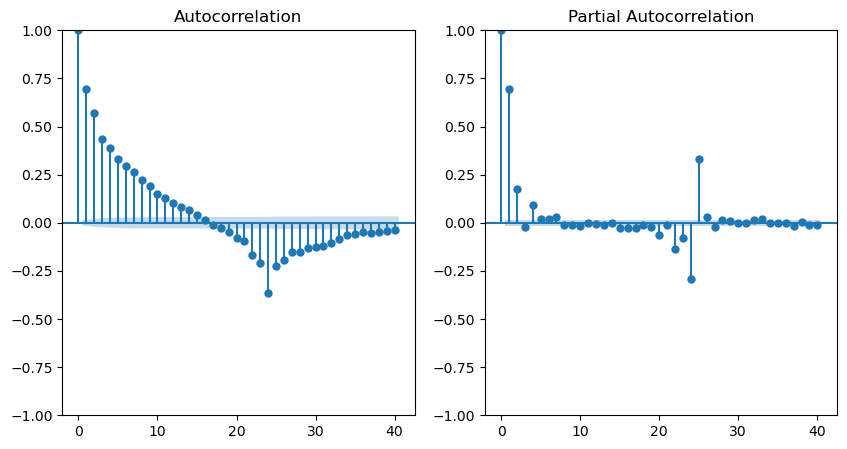

In [19]:
# if we model data using ARMA model then Partial Autocorrlation defined the order of AR and Autocorrelation of MA componenet of ARMA.
# It seems we can model using AR(3).
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf( remove_season_series_diff.values.squeeze(), lags=40, ax=ax[0])
plot_pacf(remove_season_series_diff.values.squeeze(), lags=40, ax=ax[1])
plt.show()

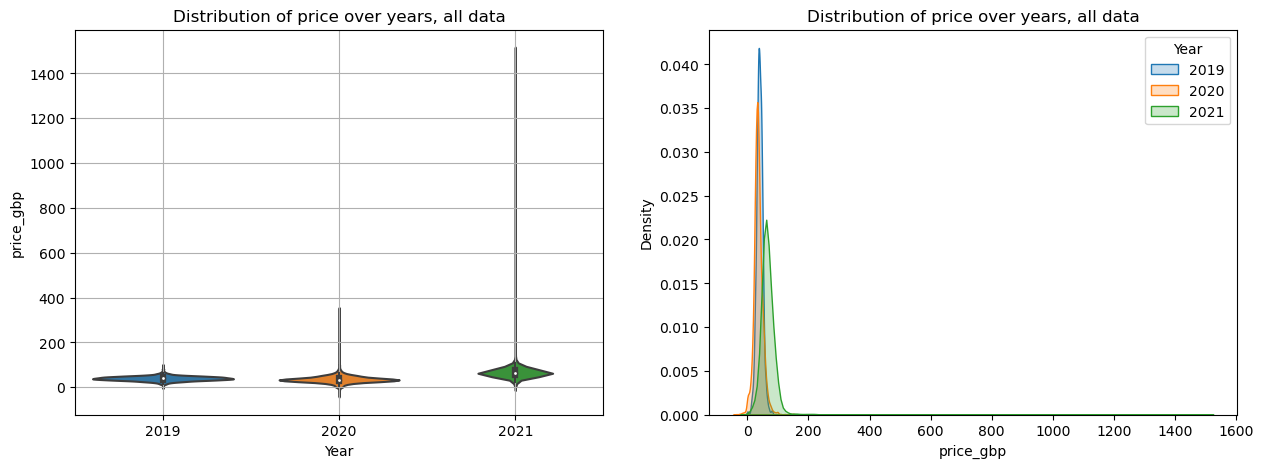

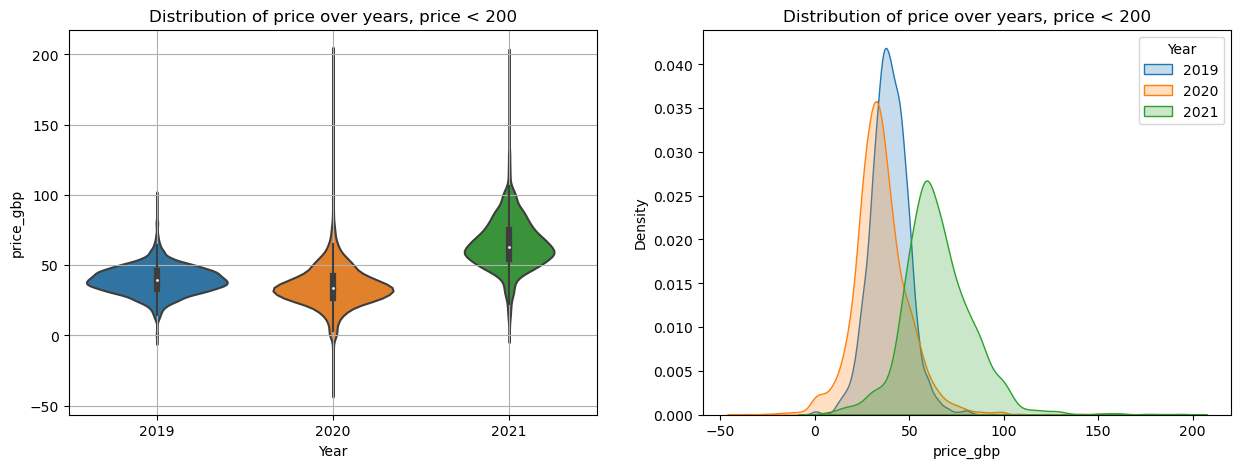

<module 'matplotlib.pyplot' from 'C:\\Users\\adolia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
# It seems we have slightly higher prices in 2021 compared with other years
years = [2019, 2020, 2021]
#
compare_variables(dataset, ["price_gbp"], groupby = "Year", title = "Distribution of price over years, all data", order = years)
reduced_dataset = dataset[dataset["price_gbp"] < 200].copy()
compare_variables(reduced_dataset, ["price_gbp"], groupby = "Year", title = "Distribution of price over years, price < 200", order = years)

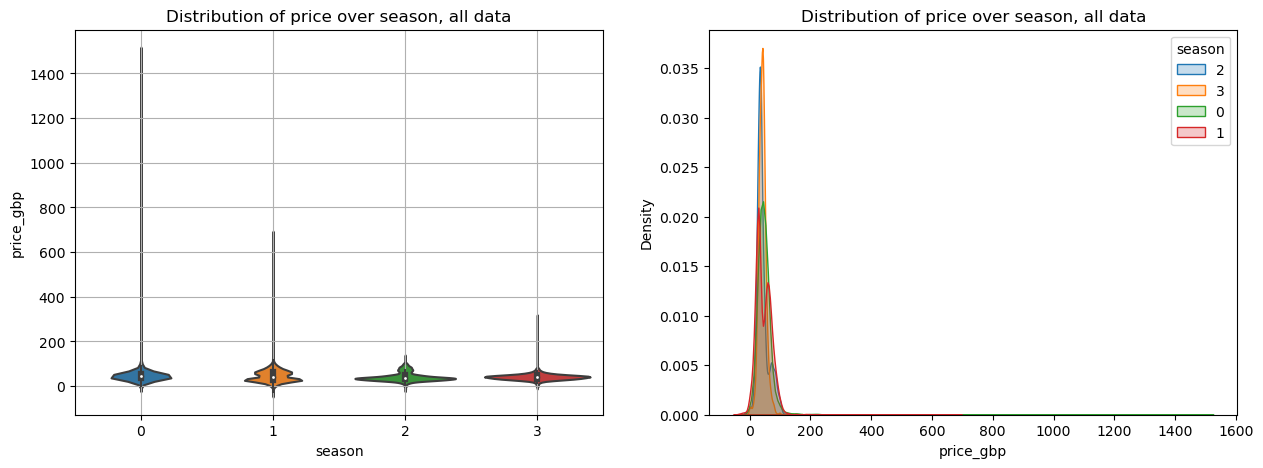

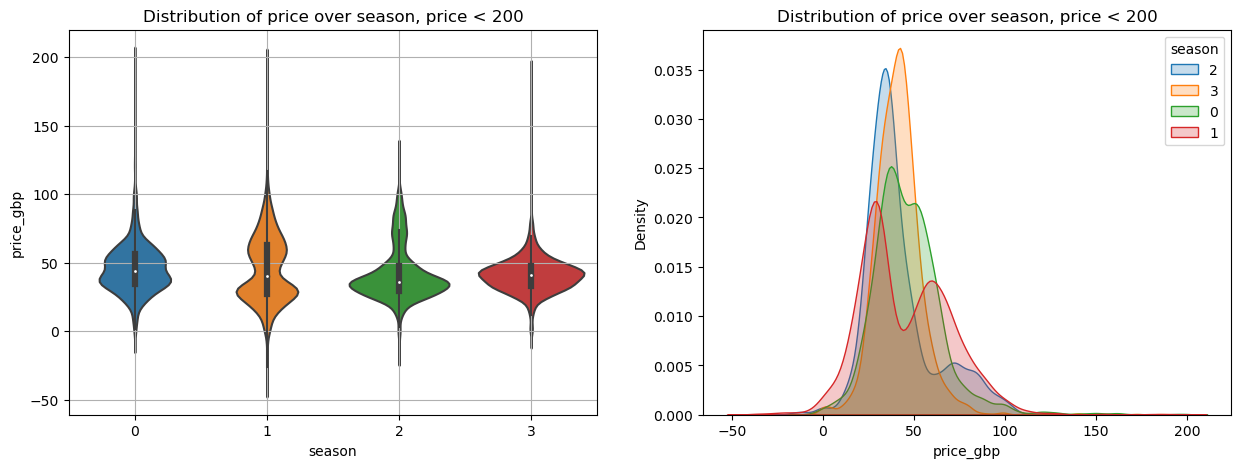

<module 'matplotlib.pyplot' from 'C:\\Users\\adolia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
# 
seasons = [0, 1, 2, 3]
#
compare_variables(dataset, ["price_gbp"], groupby = "season", title = "Distribution of price over season, all data", order = seasons)
reduced_dataset = dataset[dataset["price_gbp"] < 200].copy()
compare_variables(reduced_dataset, ["price_gbp"], groupby = "season", title = "Distribution of price over season, price < 200", order = seasons)

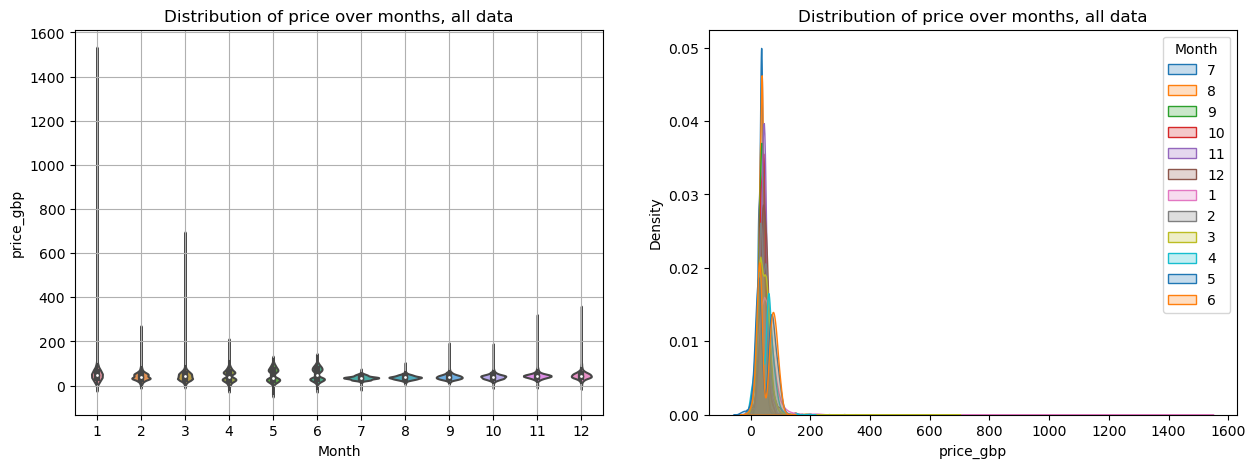

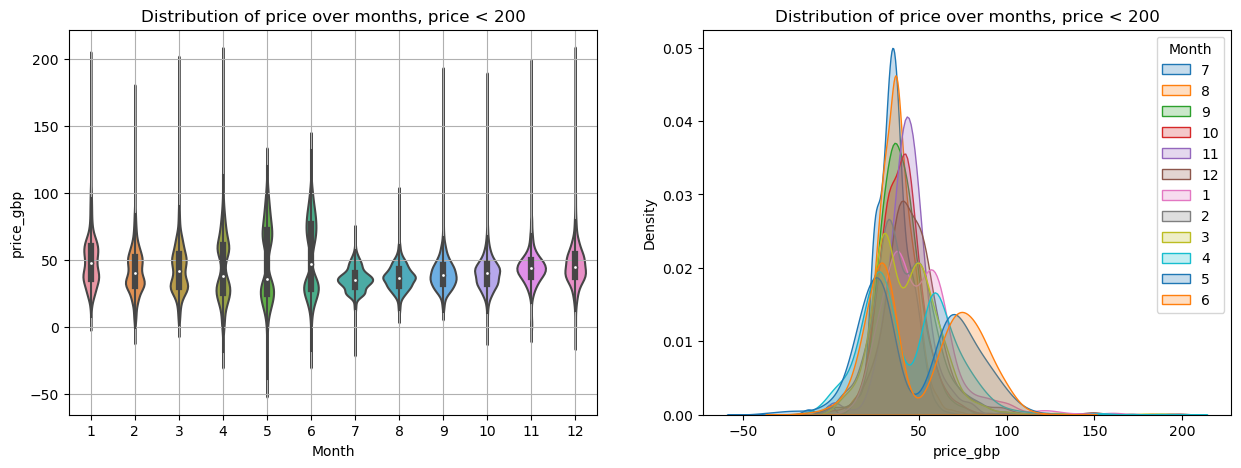

<module 'matplotlib.pyplot' from 'C:\\Users\\adolia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [22]:
# 
months = list(range(1, 12 + 1))
#
compare_variables(dataset, ["price_gbp"], groupby = "Month", title = "Distribution of price over months, all data", order = months)
reduced_dataset = dataset[dataset["price_gbp"] < 200].copy()
compare_variables(reduced_dataset, ["price_gbp"], groupby = "Month", title = "Distribution of price over months, price < 200", order = months)

In [23]:
# We have bimodal distribution for prices over months
# It is because we have upper shift in median prices in 2021
#
# the hist price in Jan 2021 it is explain in https://auroraer.com/insight/gb-wholesale-market-summary-january-2021/
# Due to colder temperatures, low renewable output levels and limited generator availability, January saw several periods
# of tight system margins. This resulted in National Grid ESO issuing both Capacity Market Notices (CMN) and 
# Electricity Margin Notices (EMN) and turning to higher marginal cost generators. Consequently, these periods saw 
# wholesale prices in excess of £500/MWh
dataset.groupby(["Month", "Year"])["price_gbp"].describe()

count       mean        std    min      25%     50%      75%  \
Month Year                                                                 
1     2020  768.0  35.914635   9.251804   7.25  29.9775  36.175  41.1300   
      2021  744.0  79.135067  98.082772  33.00  55.0000  61.000  70.0000   
2     2020  696.0  30.628764  10.442902  -4.33  25.2500  32.000  36.7850   
      2021  672.0  53.813780  17.755366  16.50  45.6625  52.125  60.4250   
3     2020  744.0  31.693427  11.337918   1.43  26.4975  30.940  36.5250   
      2021  744.0  56.840874  33.986442   1.90  47.0000  53.000  62.0000   
4     2020  720.0  24.178708  10.151824 -19.00  19.5750  26.000  31.0425   
      2021  720.0  64.882056  18.946999   5.00  56.2750  61.200  72.0000   
5     2020  744.0  22.142043  11.513904 -38.80  17.7550  24.670  29.9900   
      2021  744.0  73.807473  15.381450  10.00  65.0000  72.150  83.9550   
6     2020  720.0  26.519264   8.581261 -17.65  22.7300  28.395  32.3500   
      2021  720.0  77.897681  12.492269  52.00  69.0000  76.600  85.9250   
7     2019  648.0  41.536821   7.544703  20.92  36.0000  40.450  46.8850   
      2020  744.0  29.451505   8.649075 -16.89  25.2600  30.495  35.0075   
8     2019  744.0  38.127446   8.970030  10.40  32.2375  38.030  44.7525   
      2020  744.0  36.288333  10.654193   7.63  29.3000  35.425  40.1075   
9     2019  720.0  36.198056   9.612462  11.94  29.3400  36.000  42.9000   
      2020  720.0  43.778153  14.997972  11.30  34.8375  41.680  49.9850   
10    2019  744.0  36.884355   9.238440  11.06  30.7400  35.865  43.5975   
      2020  744.0  43.385282  15.738774  -7.18  35.9100  42.880  50.0825   
11    2019  720.0  44.457097  10.418422  16.85  37.4925  44.000  49.9250   
      2020  720.0  44.040389  20.457520  -4.36  36.7900  43.085  49.9150   
12    2019  744.0  39.094247  11.528190  -2.84  33.9875  39.330  45.1500   
      2020  744.0  55.014046  24.417865  -8.28  44.0075  52.180  60.8500   

                max  
Month Year           
1     2020    65.00  
      2021  1500.00  
2     2020    59.62  
      2021   262.50  
3     2020    99.90  
      2021   683.00  
4     2020    43.41  
      2021   200.00  
5     2020    43.22  
      2021   120.00  
6     2020    42.00  
      2021   132.00  
7     2019    71.00  
      2020    48.99  
8     2019    61.00  
      2020    99.40  
9     2019    70.00  
      2020   187.10  
10    2019    71.50  
      2020   183.20  
11    2019    98.40  
      2020   313.45  
12    2019    84.40  
      2020   350.00

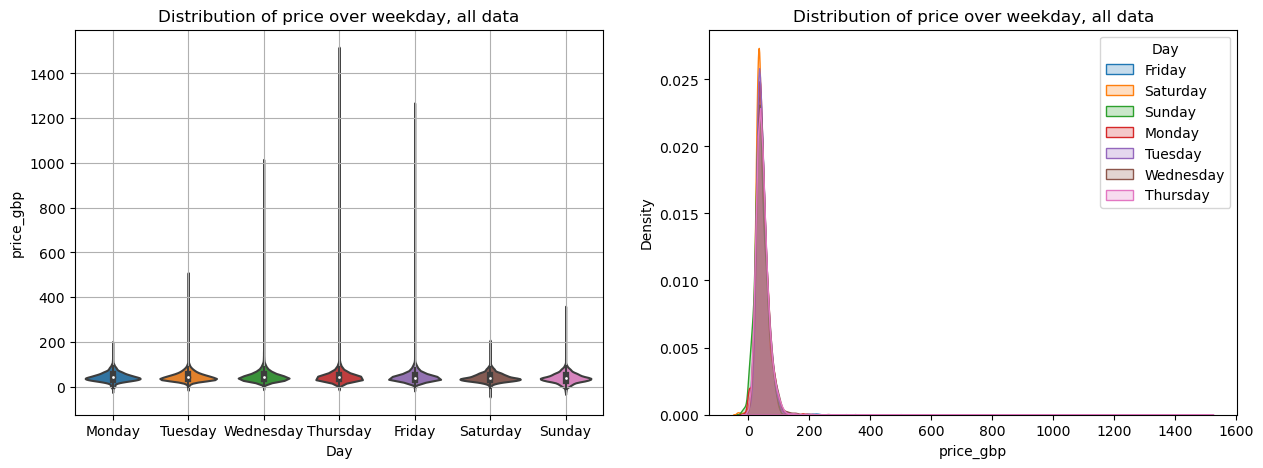

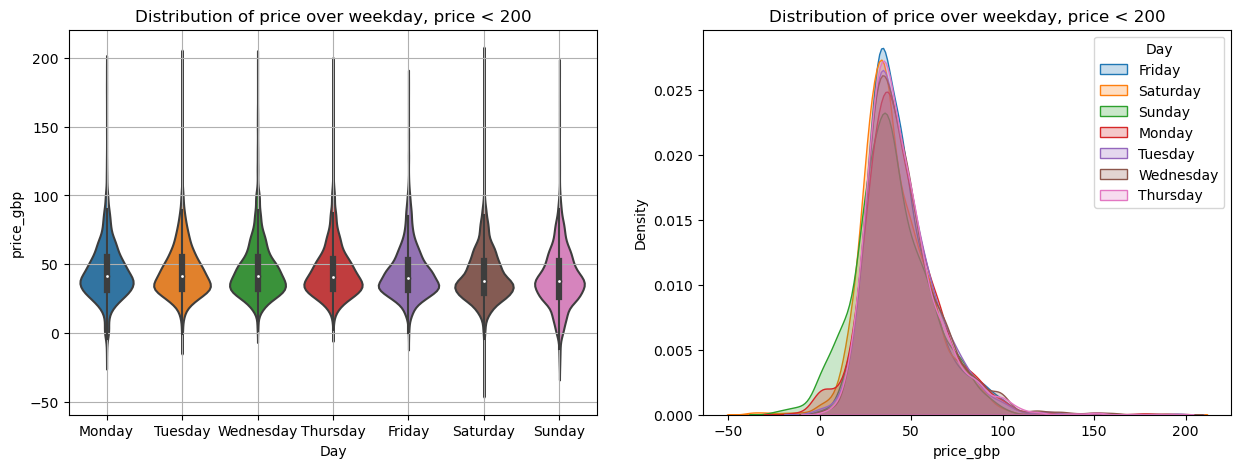

<module 'matplotlib.pyplot' from 'C:\\Users\\adolia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:
#  It seem there is no obvious difference for the prices over week day
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#
compare_variables(dataset, ["price_gbp"], groupby = "Day", title = "Distribution of price over weekday, all data", order = weekdays)
reduced_dataset = dataset[dataset["price_gbp"] < 200].copy()
compare_variables(reduced_dataset, ["price_gbp"], groupby = "Day", title = "Distribution of price over weekday, price < 200", order = weekdays)

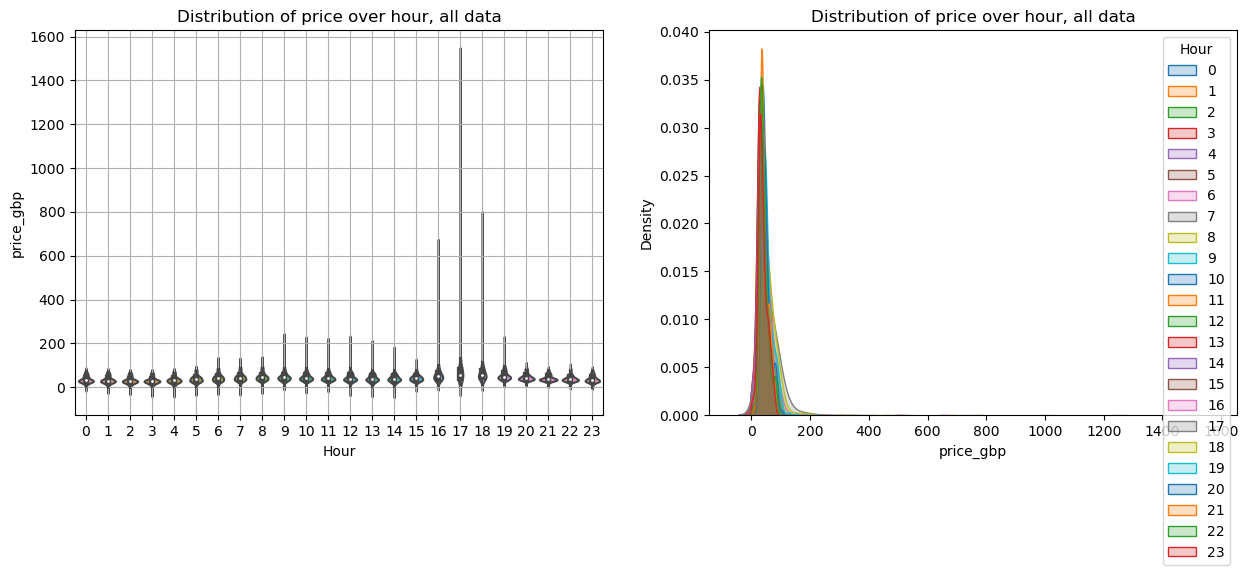

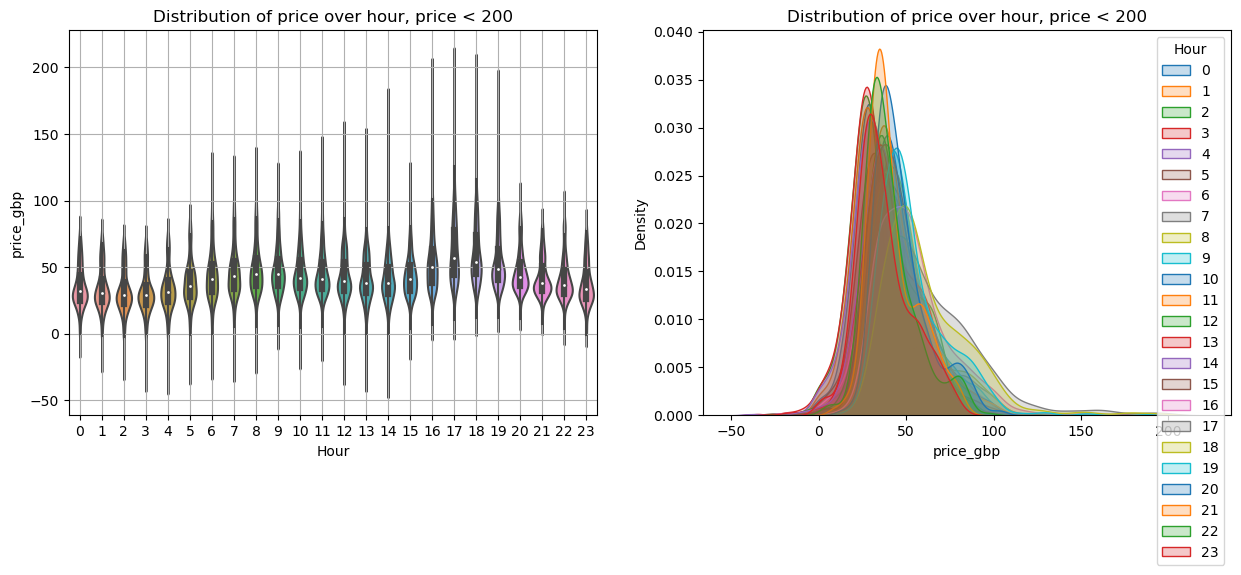

<module 'matplotlib.pyplot' from 'C:\\Users\\adolia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [25]:
# prices really depends on the hour
hours = list(range(24))
#
compare_variables(dataset, ["price_gbp"], groupby = "Hour", title = "Distribution of price over hour, all data", order = hours)
reduced_dataset = dataset[dataset["price_gbp"] < 200].copy()
compare_variables(reduced_dataset, ["price_gbp"], groupby = "Hour", title = "Distribution of price over hour, price < 200", order = hours)

# Create training dataset


### I assume that "forecast_wind_mw" has the corresponding date that was forecast for. For example if we have timestampe "01/07/2019  17:00:00" then it means that the value of "forecast_wind_mw" in the corresponding row is forecast for this date and time. Therefore, if we want to use it in our model we need to shift backward by 1 DAY (reduce date by 1 day) and merge with other information that is available on the previous day to the forecast. We do the same for the price_gbp.

In [26]:
# The dataset data.csv has been provided. These are the prices for the day ahead hourly market.
# Schema:
# ● settlement_period: start of the settlement period in local UK time zone (no need to worry about
# DST start/end)
# ● forecast_wind_mw: day ahead forecasts for wind in MW. The settlement period it is indexed
# against is for the forecasted period. You can assume you have this information from the day
# before
# ● national_demand_mw: observation of national demand in MW for the given settlement period
# ● embedded_solar_generation_mw: observation of generation of solar energy in MW
# ● price_gbo: the price we want to predict in GBP
#
copy_dataset = dataset.copy()
del copy_dataset["forecast_wind_mw"], 
copy_dataset.rename(columns = {"price_gbp": "previous_price_gbp"}, inplace = True)
copy_dataset["n"] = range(len(copy_dataset))
#
# "forecast_wind_mw is available from one day before sherefore we shift by 24 hours back
forecast_wind_mw = dataset.shift(-24)[["settlement_period", "forecast_wind_mw", "price_gbp"]].copy()
forecast_wind_mw["n"] = range(len(forecast_wind_mw))
del forecast_wind_mw["settlement_period"]
#
forecast_wind_mw = forecast_wind_mw.merge(copy_dataset, on = "n")
#
forecast_wind_mw.head(25)

forecast_wind_mw  price_gbp   n    settlement_period  national_demand_mw  \
0             4282.0      34.01   0  2019-07-05 00:00:00             20988.0   
1             4275.0      30.47   1  2019-07-05 01:00:00             20353.0   
2             4306.0      30.01   2  2019-07-05 02:00:00             19811.0   
3             4294.0      27.70   3  2019-07-05 03:00:00             19722.0   
4             4064.0      27.00   4  2019-07-05 04:00:00             20003.0   
5             3793.0      30.00   5  2019-07-05 05:00:00             23243.0   
6             3517.0      32.15   6  2019-07-05 06:00:00             27773.0   
7             3146.0      34.00   7  2019-07-05 07:00:00             28395.0   
8             2722.0      38.20   8  2019-07-05 08:00:00             28238.0   
9             2366.0      40.08   9  2019-07-05 09:00:00             27438.0   
10            2029.0      46.00  10  2019-07-05 10:00:00             27285.0   
11            1785.0      44.00  11  2019-07-05 11:00:00             27103.0   
12            1629.0      37.00  12  2019-07-05 12:00:00             26769.0   
13            1639.0      33.28  13  2019-07-05 13:00:00             26659.0   
14            1710.0      32.00  14  2019-07-05 14:00:00             26395.0   
15            1838.0      34.92  15  2019-07-05 15:00:00             27340.0   
16            2002.0      44.03  16  2019-07-05 16:00:00             28661.0   
17            2198.0      47.66  17  2019-07-05 17:00:00             29410.0   
18            2355.0      48.95  18  2019-07-05 18:00:00             29399.0   
19            2243.0      46.00  19  2019-07-05 19:00:00             28721.0   
20            2150.0      45.78  20  2019-07-05 20:00:00             27794.0   
21            2006.0      40.00  21  2019-07-05 21:00:00             27096.0   
22            1684.0      43.77  22  2019-07-05 22:00:00             24478.0   
23            1480.0      39.75  23  2019-07-05 23:00:00             21770.0   
24            1280.0      34.00  24  2019-07-06 00:00:00             20364.0   

    embedded_solar_generation_mw  previous_price_gbp                  ds  \
0                              0               32.71 2019-07-05 00:00:00   
1                              0               31.96 2019-07-05 01:00:00   
2                              0               31.93 2019-07-05 02:00:00   
3                              0               31.93 2019-07-05 03:00:00   
4                             26               32.00 2019-07-05 04:00:00   
5                            552               39.65 2019-07-05 05:00:00   
6                           1640               46.07 2019-07-05 06:00:00   
7                           3050               56.95 2019-07-05 07:00:00   
8                           4540               53.00 2019-07-05 08:00:00   
9                           5900               45.59 2019-07-05 09:00:00   
10                          6930               41.00 2019-07-05 10:00:00   
11                          7190               39.00 2019-07-05 11:00:00   
12                          7600               32.39 2019-07-05 12:00:00   
13                          7380               32.00 2019-07-05 13:00:00   
14                          6350               34.00 2019-07-05 14:00:00   
15                          5150               35.00 2019-07-05 15:00:00   
16                          3810               41.30 2019-07-05 16:00:00   
17                          2400               43.00 2019-07-05 17:00:00   
18                          1290               42.39 2019-07-05 18:00:00   
19                           506               42.29 2019-07-05 19:00:00   
20                            21               38.89 2019-07-05 20:00:00   
21                             0               35.21 2019-07-05 21:00:00   
22                             0               42.60 2019-07-05 22:00:00   
23                             0               37.60 2019-07-05 23:00:00   
24                     

In [27]:
def previous_value(x, order = 0, statistics = "median"):
    dd = x.values[::24]
    dd = dd[~np.isnan(dd)]
    #
    if   statistics == "median":
         output = np.median(dd)
    elif statistics == "std":
         output = np.std(dd)
    elif statistics == "Q25":
         output = np.quantile(dd, 0.25)
    elif statistics == "Q75":
         output = np.quantile(dd, 0.75)
    elif statistics == "max":
         output = np.max(dd)
    else:
         output = dd[order]   
    # dd = np.array(range(24*5+1))
    # array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
    #         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
    #         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
    #         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
    #         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
    #         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
    #         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
    #         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
    #        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
    #        117, 118, 119, 120])
    # In [18]: dd[::24]
    # Out[18]: array([  0,  24,  48,  72,  96, 120])
    #
    return output
#
cols       = ["forecast_wind_mw", "national_demand_mw", "embedded_solar_generation_mw", "previous_price_gbp"]
statistics = ["median", "std", "Q25", "Q75", "max", "ORDER"]
#
nprev_days = 5
window     = nprev_days * 24 + 1
center     = False
#
train_cols = []
#
for col in cols:
    print("col: ", col)
    for stat in statistics:
        if stat == "ORDER":
           for order in range(nprev_days + 1):
               forecast_wind_mw[col  + "_" + stat + "_" + str(nprev_days - order)] = forecast_wind_mw[col].rolling(window = window, center = center).apply(lambda x: previous_value(x, order = order, statistics = stat))
               train_cols.append(col  + "_" + stat + "_" + str(nprev_days - order)) 
        else:
               forecast_wind_mw[col + "_" + stat] = forecast_wind_mw[col].rolling(window = window, center = center).apply(lambda x: previous_value(x, order = None, statistics = stat))                                                                                                                        
               train_cols.append(col + "_" + stat) 
#
train_cols = train_cols + ["season", "Hour"]
forecast_wind_mw["y"] = forecast_wind_mw["price_gbp"].copy()
#
forecast_wind_mw = forecast_wind_mw[train_cols + ["ds", "y"]].copy()
#
print("Number of Features: ", len(train_cols))
print("features: ", train_cols)
print("OK")

col:  forecast_wind_mw
col:  national_demand_mw
col:  embedded_solar_generation_mw
col:  previous_price_gbp
Number of Features:  46
features:  ['forecast_wind_mw_median', 'forecast_wind_mw_std', 'forecast_wind_mw_Q25', 'forecast_wind_mw_Q75', 'forecast_wind_mw_max', 'forecast_wind_mw_ORDER_5', 'forecast_wind_mw_ORDER_4', 'forecast_wind_mw_ORDER_3', 'forecast_wind_mw_ORDER_2', 'forecast_wind_mw_ORDER_1', 'forecast_wind_mw_ORDER_0', 'national_demand_mw_median', 'national_demand_mw_std', 'national_demand_mw_Q25', 'national_demand_mw_Q75', 'national_demand_mw_max', 'national_demand_mw_ORDER_5', 'national_demand_mw_ORDER_4', 'national_demand_mw_ORDER_3', 'national_demand_mw_ORDER_2', 'national_demand_mw_ORDER_1', 'national_demand_mw_ORDER_0', 'embedded_solar_generation_mw_median', 'embedded_solar_generation_mw_std', 'embedded_solar_generation_mw_Q25', 'embedded_solar_generation_mw_Q75', 'embedded_solar_generation_mw_max', 'embedded_solar_generation_mw_ORDER_5', 'embedded_solar_generation_mw

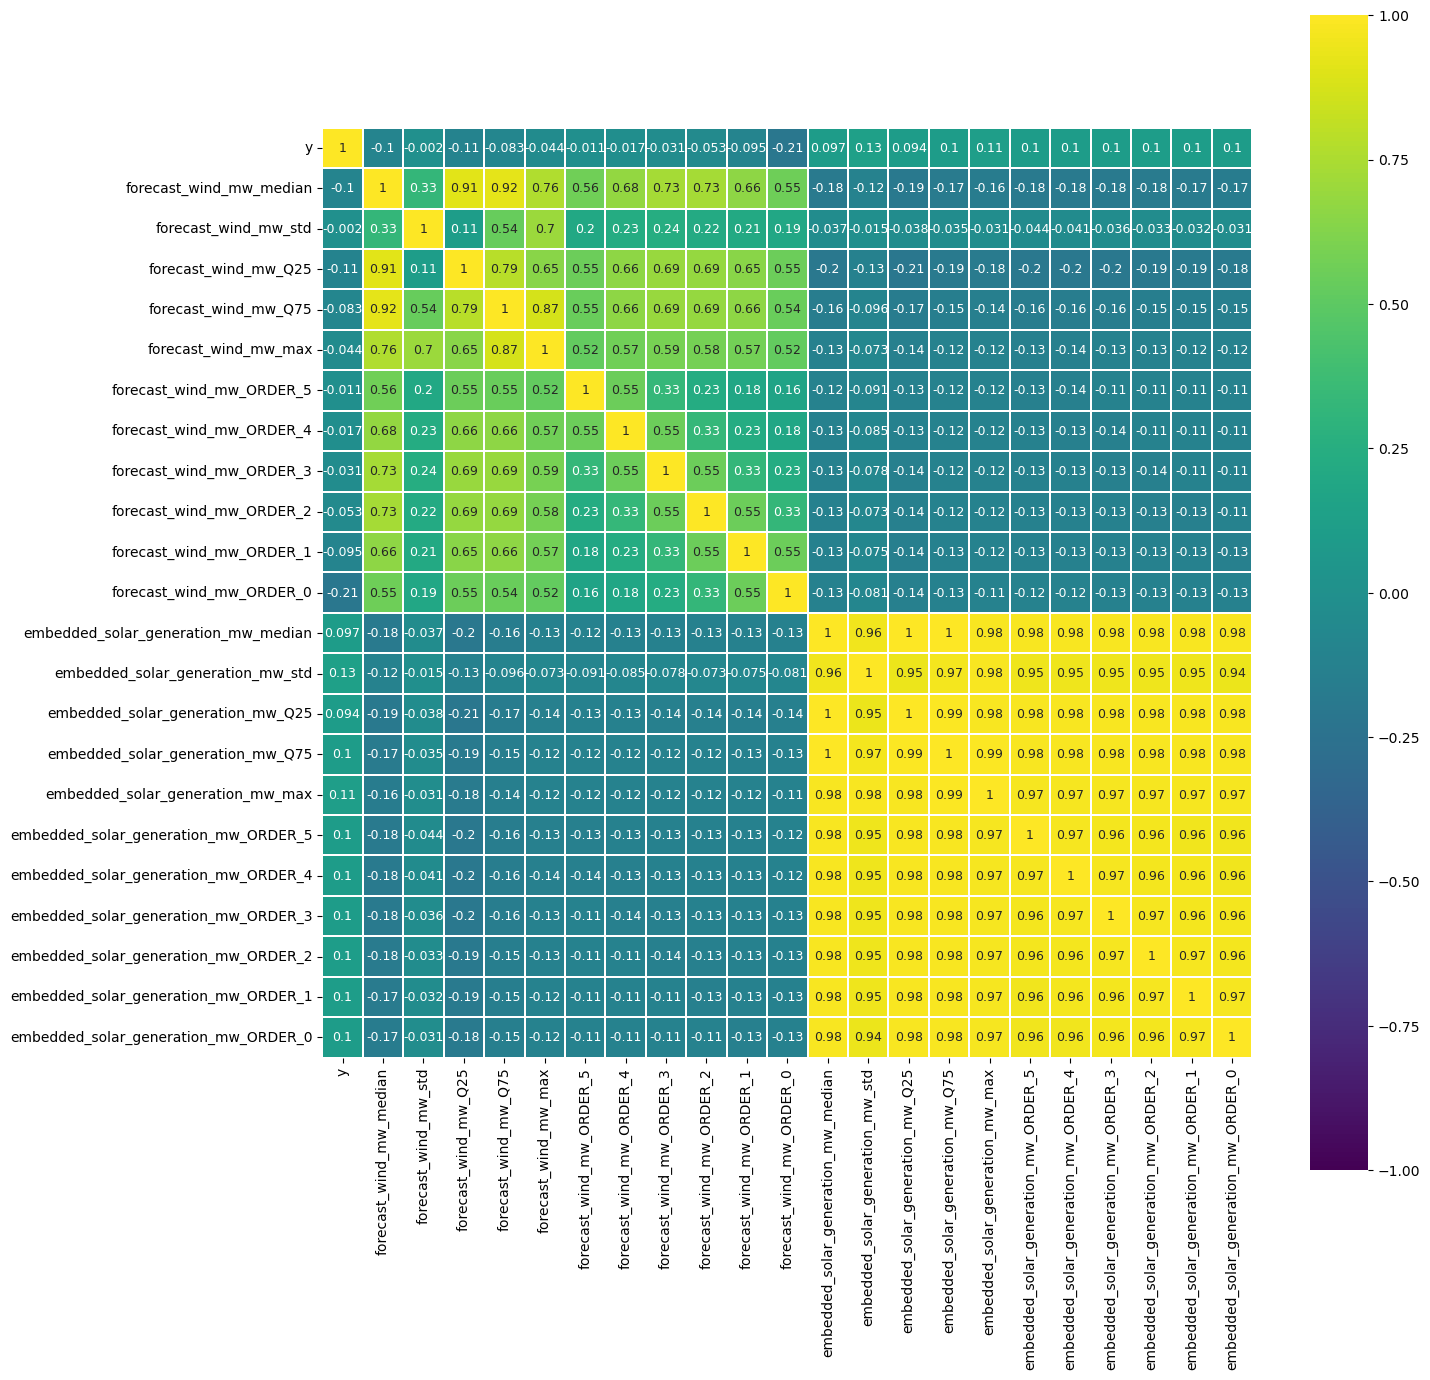

In [28]:
# Correlation measure linear relation strength between two variable. If we have a small value then it does not mean that 
# there is no relationship between two variables - there can be non linear relationship
forecast_cols = ['forecast_wind_mw_median', 'forecast_wind_mw_std', 'forecast_wind_mw_Q25', 'forecast_wind_mw_Q75', 'forecast_wind_mw_max', 'forecast_wind_mw_ORDER_5', 'forecast_wind_mw_ORDER_4', 'forecast_wind_mw_ORDER_3', 'forecast_wind_mw_ORDER_2', 'forecast_wind_mw_ORDER_1', 'forecast_wind_mw_ORDER_0']
solar_cols    = ['embedded_solar_generation_mw_median', 'embedded_solar_generation_mw_std', 'embedded_solar_generation_mw_Q25', 'embedded_solar_generation_mw_Q75', 'embedded_solar_generation_mw_max', 'embedded_solar_generation_mw_ORDER_5', 'embedded_solar_generation_mw_ORDER_4', 'embedded_solar_generation_mw_ORDER_3', 'embedded_solar_generation_mw_ORDER_2', 'embedded_solar_generation_mw_ORDER_1', 'embedded_solar_generation_mw_ORDER_0']

corr =  forecast_wind_mw[ ["y"] + forecast_cols + solar_cols].corr(method = "spearman")
plt.figure(figsize = (15,15))
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);            

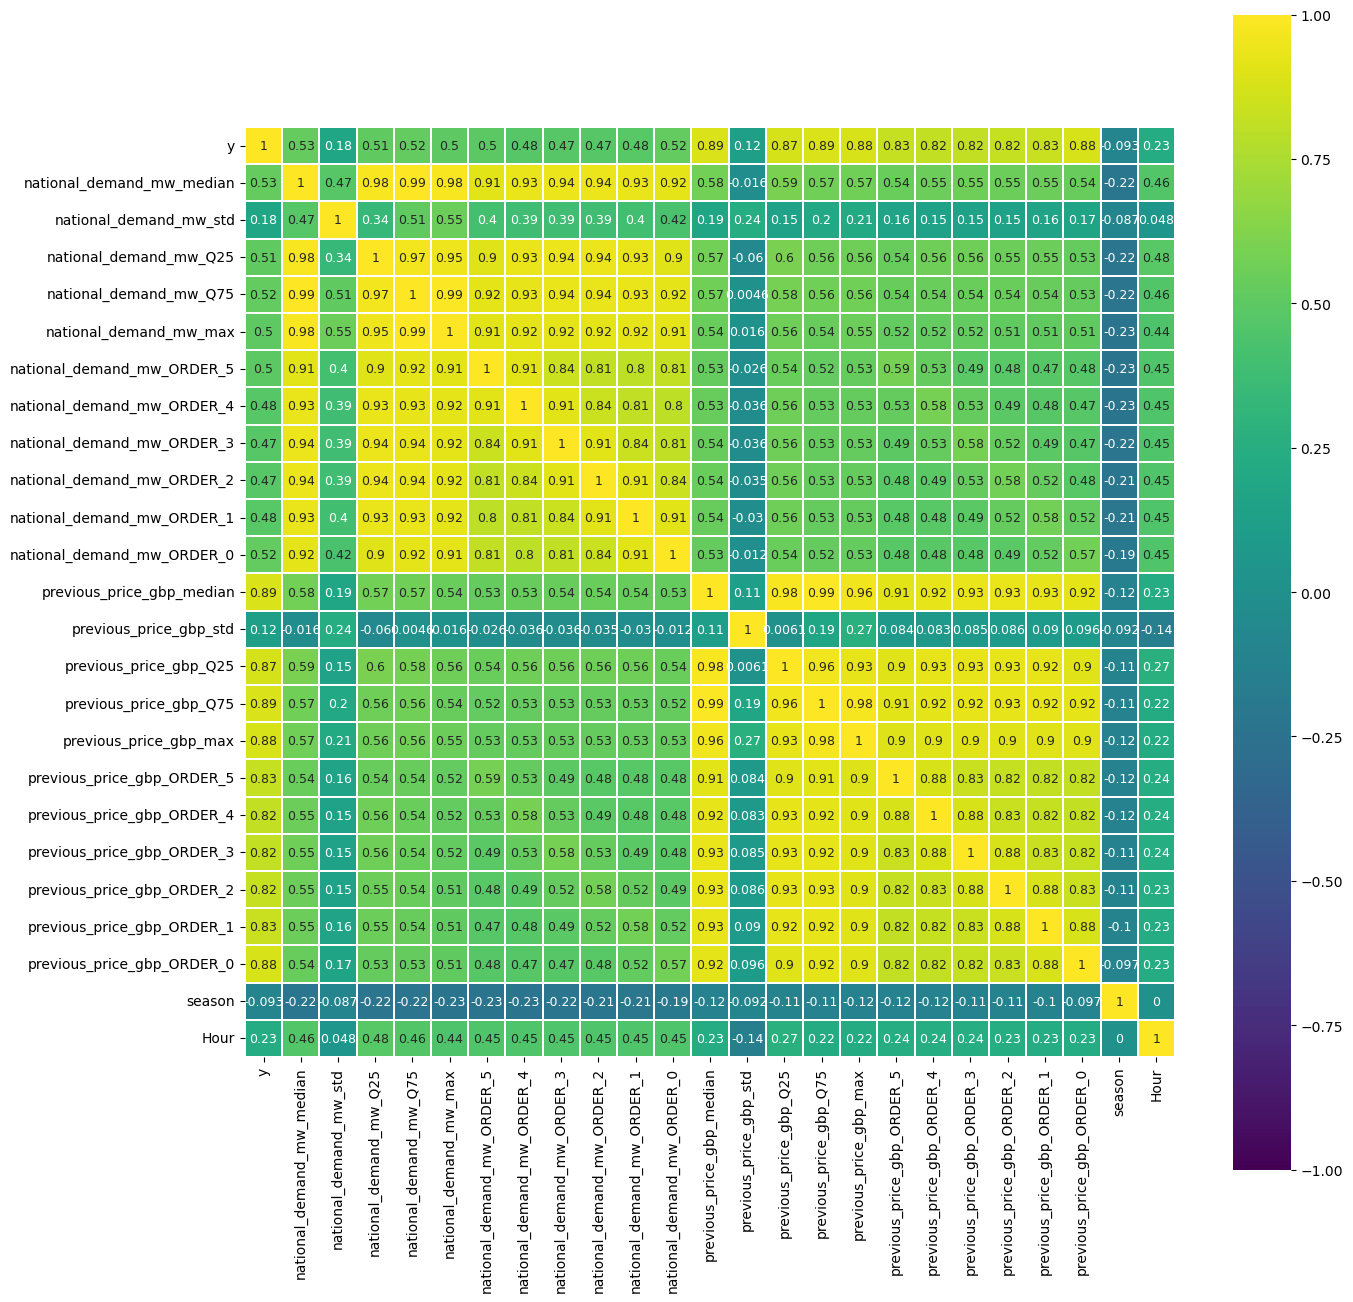

In [29]:
# But there is strong relationship between price and energy demand. 
national_demand_cols = ['national_demand_mw_median', 'national_demand_mw_std', 'national_demand_mw_Q25', 'national_demand_mw_Q75', 'national_demand_mw_max', 'national_demand_mw_ORDER_5', 'national_demand_mw_ORDER_4', 'national_demand_mw_ORDER_3', 'national_demand_mw_ORDER_2', 'national_demand_mw_ORDER_1', 'national_demand_mw_ORDER_0']
previous_price_cols  = ['previous_price_gbp_median', 'previous_price_gbp_std', 'previous_price_gbp_Q25', 'previous_price_gbp_Q75', 'previous_price_gbp_max', 'previous_price_gbp_ORDER_5', 'previous_price_gbp_ORDER_4', 'previous_price_gbp_ORDER_3', 'previous_price_gbp_ORDER_2', 'previous_price_gbp_ORDER_1', 'previous_price_gbp_ORDER_0', 'season', 'Hour']

corr =  forecast_wind_mw[ ["y"] + national_demand_cols + previous_price_cols].corr(method = "spearman")
plt.figure(figsize = (15, 15))
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

In [30]:
#create train, validation and test datasets
nnn = len(forecast_wind_mw)
#
sub_forecast_wind_mw = forecast_wind_mw[train_cols + ["ds", "y"]].copy()
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      sub_forecast_wind_mw.isnull().sum())
#
sub_forecast_wind_mw = sub_forecast_wind_mw.dropna()
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      sub_forecast_wind_mw.isnull().sum())
#
train = sub_forecast_wind_mw.head(int(0.6 * nnn))
val_test = sub_forecast_wind_mw[~sub_forecast_wind_mw["ds"].isin(train["ds"].values)].copy()
val = val_test.head(int(0.5 * len(val_test)))
test = val_test[~val_test["ds"].isin(val["ds"].values)].copy()
#
print("train:")
display(train.head())
display(train.tail())
print("val:")
display(val.head())
display(val.tail())
print("test:")
display(test.head())
display(test.tail())

 
Count total NaN at each column in a DataFrame : 

 forecast_wind_mw_median                 144
forecast_wind_mw_std                    144
forecast_wind_mw_Q25                    144
forecast_wind_mw_Q75                    144
forecast_wind_mw_max                    144
forecast_wind_mw_ORDER_5                144
forecast_wind_mw_ORDER_4                144
forecast_wind_mw_ORDER_3                144
forecast_wind_mw_ORDER_2                144
forecast_wind_mw_ORDER_1                144
forecast_wind_mw_ORDER_0                144
national_demand_mw_median               120
national_demand_mw_std                  120
national_demand_mw_Q25                  120
national_demand_mw_Q75                  120
national_demand_mw_max                  120
national_demand_mw_ORDER_5              120
national_demand_mw_ORDER_4              120
national_demand_mw_ORDER_3              120
national_demand_mw_ORDER_2              120
national_demand_mw_ORDER_1              120
national_demand_mw_ORDE

forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
120                   1341.5           1175.933908               1172.00   
121                   1253.0           1186.956566               1096.25   
122                   1216.0           1203.967850               1045.00   
123                   1208.0           1197.992487               1009.50   
124                   1209.0           1106.445610               1015.75   

     forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
120               1406.75                4282.0                    4282.0   
121               1390.25                4275.0                    4275.0   
122               1377.25                4306.0                    4306.0   
123               1378.75                4294.0                    4294.0   
124               1381.25                4064.0                    4064.0   

     forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
120                    1280.0                    1403.0   
121                    1127.0                    1379.0   
122                    1066.0                    1366.0   
123                    1059.0                    1357.0   
124                    1117.0                    1301.0   

     forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
120                     719.0                    1136.0  ...   
121                     737.0                    1086.0  ...   
122                     770.0                    1038.0  ...   
123                     823.0                     993.0  ...   
124                     868.0                     982.0  ...   

     previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
120                       32.71                       34.01   
121                       31.96                       30.47   
122                       31.93                       30.01   
123                       31.93                       27.70   
124                       32.00                       27.00   

     previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
120                       34.00                       32.00   
121                       35.34                       30.30   
122                       34.00                       30.00   
123                       31.53                       29.99   
124                       29.54                       31.00   

     previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
120                       33.07                       35.20       2     0   
121                       33.04                       34.00       2     1   
122                       32.97                       34.00       2     2   
123                       32.96                       33.99       2     3   
124                       33.42                       36.40       2     4   

                     ds      y  
120 2019-07-10 00:00:00  32.94  
121 2019-07-10 01:00:00  32.48  
122 2019-07-10 02:00:00  32.44  
123 2019-07-10 03:00:00  33.31  
124 2019-07-10 04:00:00  36.96  

[5 rows x 48 columns]

forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
10598                   3422.5           2428.113288               1905.00   
10599                   3563.0           2354.105946               1884.25   
10600                   3875.5           2223.217613               1908.75   
10601                   4049.5           2161.171827               2102.75   
10602                   4245.5           2073.551523               2349.25   

       forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
10598               4172.75                8519.0                    8519.0   
10599               4507.50                8218.0                    8218.0   
10600               4837.25                7691.0                    7691.0   
10601               5144.25                7462.0                    7462.0   
10602               5389.50                7188.0                    7188.0   

       forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
10598                    1601.0                    1133.0   
10599                    1531.0                    1146.0   
10600                    1458.0                    1165.0   
10601                    1666.0                    1152.0   
10602                    1942.0                    1172.0   

       forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
10598                    4221.0                    2817.0  ...   
10599                    4616.0                    2944.0  ...   
10600                    4953.0                    3261.0  ...   
10601                    5297.0                    3413.0  ...   
10602                    5546.0                    3571.0  ...   

       previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
10598                       34.94                       28.86   
10599                       36.95                       38.00   
10600                       47.00                       47.60   
10601                       53.00                       52.00   
10602                       54.39                       57.99   

       previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
10598                       49.00                       63.12   
10599                       60.04                       78.14   
10600                       73.22                      123.38   
10601                      109.03                      170.62   
10602                       87.20                      140.00   

       previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
10598                       41.00                       44.99       3    14   
10599                       54.00                       53.09       3    15   
10600                       61.66                       63.01       3    16   
10601                       65.97                       75.64       3    17   
10602                       57.20                       62.00       3    18   

                       ds      y  
10598 2020-09-17 14:00:00  36.36  
10599 2020-09-17 15:00:00  42.29  
10600 2020-09-17 16:00:00  49.50  
10601 2020-09-17 17:00:00  52.44  
10602 2020-09-17 18:00:00  48.69  

[5 rows x 48 columns]

val:


forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
10603                   4461.0           1910.640527               2621.75   
10604                   4609.0           1758.430021               2955.50   
10605                   4595.5           1629.950451               3227.25   
10606                   4342.5           1519.817140               3186.00   
10607                   4654.5           1857.272074               2624.50   

       forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
10603               5362.75                6809.0                    6809.0   
10604               5466.75                6454.0                    6454.0   
10605               5621.75                6100.0                    6100.0   
10606               5484.75                5784.0                    5694.0   
10607               5690.75                6656.0                    5847.0   

       forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
10603                    2256.0                    1259.0   
10604                    2638.0                    1376.0   
10605                    2962.0                    1485.0   
10606                    2972.0                    1538.0   
10607                    2137.0                    1619.0   

       forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
10603                    5416.0                    3719.0  ...   
10604                    5310.0                    3908.0  ...   
10605                    5168.0                    4023.0  ...   
10606                    4857.0                    3828.0  ...   
10607                    5222.0                    4087.0  ...   

       previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
10603                       46.00                       56.00   
10604                       40.83                       49.92   
10605                       36.41                       37.65   
10606                       33.03                       34.58   
10607                       30.74                       32.67   

       previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
10603                       62.84                       73.39   
10604                       51.17                       59.94   
10605                       42.00                       46.44   
10606                       37.20                       45.15   
10607                       36.51                       41.43   

       previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
10603                       48.43                       50.37       3    19   
10604                       43.95                       42.93       3    20   
10605                       39.63                       37.37       3    21   
10606                       38.15                       35.64       3    22   
10607                       34.01                       32.75       3    23   

                       ds      y  
10603 2020-09-17 19:00:00  44.77  
10604 2020-09-17 20:00:00  39.97  
10605 2020-09-17 21:00:00  36.00  
10606 2020-09-17 22:00:00  37.29  
10607 2020-09-17 23:00:00  34.10  

[5 rows x 48 columns]

forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
14020                   9217.5           1843.435629               7727.00   
14021                   8849.5           1784.125128               7907.25   
14022                   8575.0           1755.939326               8087.75   
14023                   8591.0           1751.706945               8152.50   
14024                   8652.5           1759.657227               8034.00   

       forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
14020              10564.00               12316.0                   10243.0   
14021              10328.00               12251.0                    9560.0   
14022              10145.25               12168.0                    8985.0   
14023              10006.75               12125.0                    8580.0   
14024              10048.00               12078.0                    8283.0   

       forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
14020                    8192.0                    7217.0   
14021                    8139.0                    7021.0   
14022                    8062.0                    6847.0   
14023                    8010.0                    6720.0   
14024                    7951.0                    6638.0   

       forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
14020                    7572.0                   12316.0  ...   
14021                    7830.0                   12251.0  ...   
14022                    8165.0                   12168.0  ...   
14023                    8602.0                   12125.0  ...   
14024                    9022.0                   12078.0  ...   

       previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
14020                       36.00                        33.1   
14021                       44.00                        44.0   
14022                       52.40                        55.0   
14023                       55.25                        54.2   
14024                       58.40                        58.5   

       previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
14020                        43.0                        46.0   
14021                        47.5                        50.2   
14022                        57.0                        56.0   
14023                        55.8                        56.0   
14024                        59.0                        59.0   

       previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
14020                       45.00                       22.00       0     4   
14021                       43.95                       20.00       0     5   
14022                       47.00                       30.00       0     6   
14023                       50.00                       38.83       0     7   
14024                       52.00                       56.17       0     8   

                       ds     y  
14020 2021-02-07 04:00:00  32.2  
14021 2021-02-07 05:00:00  44.0  
14022 2021-02-07 06:00:00  54.4  
14023 2021-02-07 07:00:00  57.0  
14024 2021-02-07 08:00:00  62.0  

[5 rows x 48 columns]

test:


forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
14025                   8761.0           1807.746203               7993.25   
14026                   8935.0           1962.184278               8008.75   
14027                   9126.5           2146.546063               7928.00   
14028                   9321.5           2309.958129               7800.75   
14029                   9410.5           2418.732272               7589.75   

       forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
14025              10169.25               12093.0                    8075.0   
14026              10444.75               12327.0                    8032.0   
14027              10670.75               12523.0                    8012.0   
14028              10814.50               12606.0                    8028.0   
14029              10902.00               12522.0                    8102.0   

       forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
14025                    7966.0                    6555.0   
14026                    8001.0                    6368.0   
14027                    7900.0                    6064.0   
14028                    7725.0                    5727.0   
14029                    7419.0                    5422.0   

       forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
14025                    9447.0                   12093.0  ...   
14026                    9838.0                   12327.0  ...   
14027                   10241.0                   12523.0  ...   
14028                   10615.0                   12606.0  ...   
14029                   10963.0                   12522.0  ...   

       previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
14025                        59.0                        61.0   
14026                        57.8                        61.6   
14027                        58.0                        60.5   
14028                        62.0                        65.0   
14029                        59.0                        62.0   

       previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
14025                        61.0                        63.0   
14026                        61.3                        62.0   
14027                        58.1                        60.9   
14028                        63.0                        64.6   
14029                        60.9                        60.4   

       previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
14025                        57.0                        54.0       0     9   
14026                        61.0                        61.0       0    10   
14027                        61.1                        57.0       0    11   
14028                        69.0                        63.1       0    12   
14029                        64.0                        63.1       0    13   

                       ds     y  
14025 2021-02-07 09:00:00  59.0  
14026 2021-02-07 10:00:00  58.0  
14027 2021-02-07 11:00:00  58.4  
14028 2021-02-07 12:00:00  62.0  
14029 2021-02-07 13:00:00  63.0  

[5 rows x 48 columns]

forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
17443                   2615.0            953.544907               1827.00   
17444                   2517.5            892.953900               1851.75   
17445                   2433.5            829.243715               1867.00   
17446                   2342.5            754.998841               1791.25   
17447                   2615.0            713.924230               1703.75   

       forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
17443               3121.75                3704.0                    3704.0   
17444               3059.50                3494.0                    3494.0   
17445               2997.00                3254.0                    3254.0   
17446               2809.00                3046.0                    2928.0   
17447               3067.25                3185.0                    3185.0   

       forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
17443                    1578.0                    3277.0   
17444                    1645.0                    3225.0   
17445                    1699.0                    3164.0   
17446                    1644.0                    3046.0   
17447                    1499.0                    3119.0   

       forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
17443                     907.0                    2656.0  ...   
17444                     881.0                    2563.0  ...   
17445                     863.0                    2496.0  ...   
17446                     858.0                    2452.0  ...   
17447                    1480.0                    2912.0  ...   

       previous_price_gbp_ORDER_5  previous_price_gbp_ORDER_4  \
17443                        90.7                        90.0   
17444                        82.9                        85.0   
17445                        76.0                        82.0   
17446                        80.0                        86.0   
17447                        71.1                        85.0   

       previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
17443                       98.00                       91.70   
17444                       90.00                       87.00   
17445                       83.55                       79.00   
17446                       99.00                       94.60   
17447                       81.00                       75.95   

       previous_price_gbp_ORDER_1  previous_price_gbp_ORDER_0  season  Hour  \
17443                        98.0                        81.8       2    19   
17444                        89.2                        80.0       2    20   
17445                        78.5                        77.0       2    21   
17446                        82.6                        82.3       2    22   
17447                        80.0                        79.0       2    23   

                       ds     y  
17443 2021-06-29 19:00:00  87.0  
17444 2021-06-29 20:00:00  85.0  
17445 2021-06-29 21:00:00  80.1  
17446 2021-06-29 22:00:00  82.5  
17447 2021-06-29 23:00:00  77.5  

[5 rows x 48 columns]

09:58:01 - cmdstanpy - INFO - Chain [1] start processing
09:58:04 - cmdstanpy - INFO - Chain [1] done processing


Validation, MAE:  15.521013120826204 , MRAE:  41.340732764271635
Test, MAE:  24.285835580557205 , MRAE:  13.26664086329969


ds        yhat  yhat_lower  yhat_upper      y
3412 2021-06-29 13:00:00  101.321802   54.149697  148.988141   79.5
3413 2021-06-29 14:00:00  102.263479   56.665049  152.289119   81.0
3414 2021-06-29 15:00:00  106.699498   61.165594  152.606901   90.0
3415 2021-06-29 16:00:00  112.949758   67.029505  160.835404  100.9
3416 2021-06-29 17:00:00  117.675333   70.597668  166.074586  102.0
3417 2021-06-29 18:00:00  118.198666   71.256437  165.861210   97.9
3418 2021-06-29 19:00:00  114.452719   66.350218  160.662773   87.0
3419 2021-06-29 20:00:00  108.865286   61.278326  154.919932   85.0
3420 2021-06-29 21:00:00  104.295613   56.995288  151.145619   80.1
3421 2021-06-29 22:00:00  101.867480   55.575075  149.699238   82.5
3422 2021-06-29 23:00:00  100.563651   53.053562  145.359296   77.5

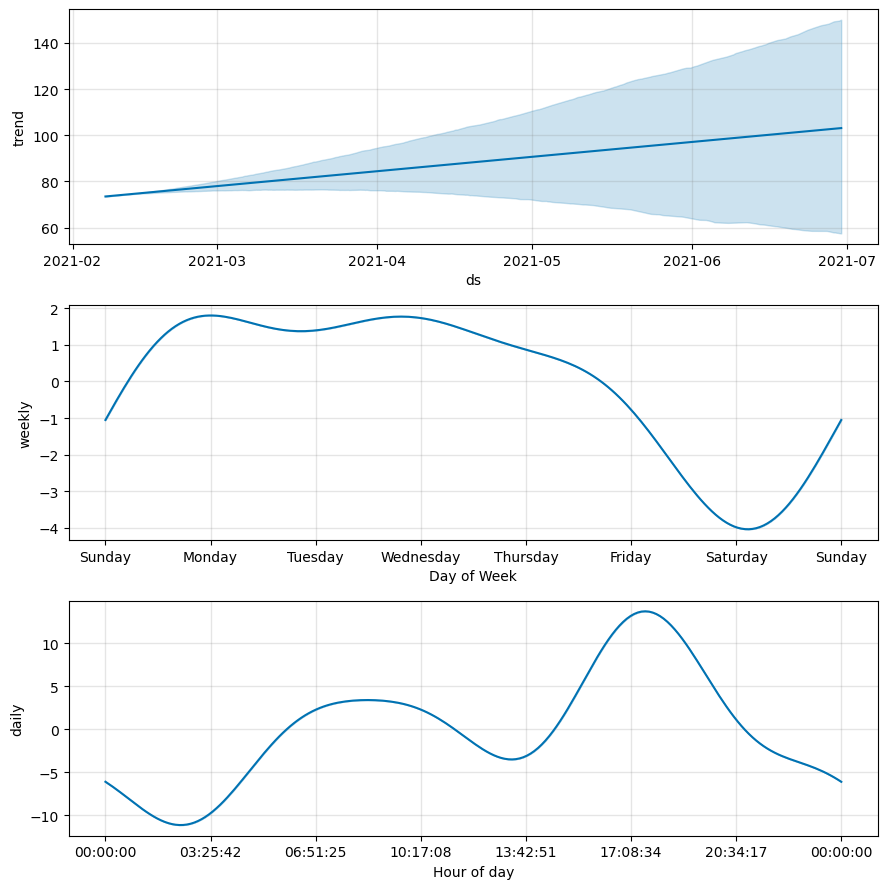

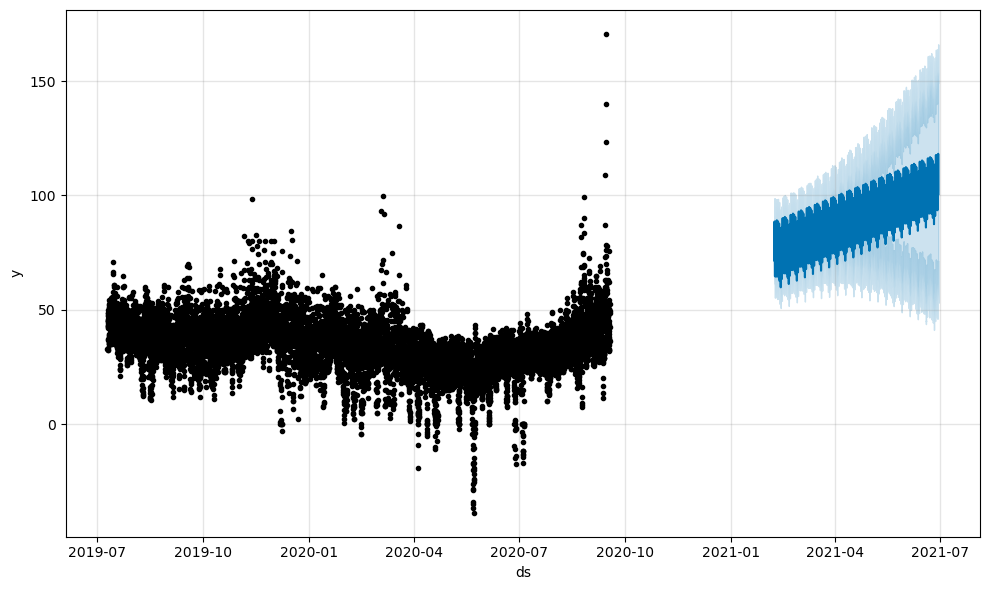

In [31]:
# Face book Prophet using timestaamp and prices only
fp = Prophet(
    #seasonality_mode="multiplicative",
    yearly_seasonality = False,
    weekly_seasonality = False,
    daily_seasonality  = False,
)
#
#m = Prophet(changepoint_prior_scale=0.01).fit(train)
basic_m = Prophet().fit(train)
#
wo_inputs_val_MAE, wo_inputs_val_MRAE = preformance(basic_m, val)
print("Validation, MAE: ", wo_inputs_val_MAE, ", MRAE: ", wo_inputs_val_MRAE)
#
wo_inputs_test_MAE, wo_inputs_test_MRAE = preformance(basic_m, test)
print("Test, MAE: ", wo_inputs_test_MAE, ", MRAE: ", wo_inputs_test_MRAE)
#
forecast = basic_m.predict(test)
forecast = forecast.merge(test[["ds", "y"]], on = "ds")
fig1 = basic_m.plot_components(forecast)
fig2 = basic_m.plot(forecast)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', "y"]].tail(11))

In [32]:
# Feedrorwar feature selection
# adding one feature at a time based on val_MRAE
# 
# 1) We start we no features, selected_cols = []. Then select the best feature with the smallest val_MRAE.
# If it is smaller than min_MRAE we add it to selected_cols.
# 2) Then again we look at all feature except selected and find the one that when we combine it with the selected_cols 
# it gives smallest val_MRAE.
# If the obtained val_MRAE is smaller than min_MRAE we add it to selected_cols.
# We repeat 2) until we can not find the feature that can reduce  min_MRAE.
#
train = train.dropna()
#
results = []
# 
selected_cols = [] #"season", "Hour", "forecast_wind_mw_ORDER_4", "forecast_wind_mw_std"]
min_MRAE = wo_inputs_val_MRAE
not_stop = True
#
# Short time series can definitely have sensitivity to the parameters, particularly the changepoint_prior_scale.
# This can significantly impact the prediction: A very small value will force a linear trend, 
# while a large value will allow the trend to fluctuate quite a bit 
# (and, if there is little data, possibly capture seasonal effects).
#
number_of_inputs = 0
while not_stop:
      candidate_col = None
      for feature in train_cols:
          print(feature)  
          if not ( feature in selected_cols ):  
             #
             fp = Prophet(yearly_seasonality = True, changepoint_prior_scale=0.01)
             #
             for sub_feature in selected_cols + [feature]:
                 fp.add_regressor(sub_feature, standardize = True)  
             #
             m = fp.fit(train)
             #
             val_MAE,  val_MRAE  = preformance(m, val)
             test_MAE, test_MRAE = preformance(m, test)
             #
             elem = {"number_of_select_inputs": len(selected_cols), "feature": feature, "val_MAE": val_MAE, "val_MRAE": val_MRAE, "test_MAE": test_MAE, "test_MRAE": test_MRAE}
             print(elem)
             results.append(elem)
             #
             if min_MRAE > val_MRAE:
                print("!!! feature: ", feature, ", val_MRAE: ", val_MRAE, ", min_MRAE: ", min_MRAE, ", selected_cols: ", selected_cols)
                min_MRAE = val_MRAE
                candidate_col = feature
      #
      if candidate_col is not None:
         selected_cols.append(candidate_col)
      else:
         not_stop = False               
#
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by = "val_MRAE")

forecast_wind_mw_median


09:58:10 - cmdstanpy - INFO - Chain [1] start processing
09:58:12 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_median', 'val_MAE': 26.7360906192599, 'val_MRAE': 26.97931893243019, 'test_MAE': 41.14450072693054, 'test_MRAE': 9.256342908176396}
!!! feature:  forecast_wind_mw_median , val_MRAE:  26.97931893243019 , min_MRAE:  41.340732764271635 , selected_cols:  []
forecast_wind_mw_std


09:58:16 - cmdstanpy - INFO - Chain [1] start processing
09:58:17 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_std', 'val_MAE': 27.679246298275324, 'val_MRAE': 26.06412663972761, 'test_MAE': 42.49609960336743, 'test_MRAE': 9.881052623259764}
!!! feature:  forecast_wind_mw_std , val_MRAE:  26.06412663972761 , min_MRAE:  26.97931893243019 , selected_cols:  []
forecast_wind_mw_Q25


09:58:21 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_Q25', 'val_MAE': 26.396551663161038, 'val_MRAE': 27.35326793590222, 'test_MAE': 40.05454309209489, 'test_MRAE': 8.684968645609676}
forecast_wind_mw_Q75


09:58:26 - cmdstanpy - INFO - Chain [1] start processing
09:58:28 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_Q75', 'val_MAE': 26.32523321999816, 'val_MRAE': 27.44135077271714, 'test_MAE': 40.341729861185016, 'test_MRAE': 8.925267324174902}
forecast_wind_mw_max


09:58:31 - cmdstanpy - INFO - Chain [1] start processing
09:58:33 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_max', 'val_MAE': 25.795111098744243, 'val_MRAE': 28.08295707421818, 'test_MAE': 38.37457978663144, 'test_MRAE': 8.210256452101218}
forecast_wind_mw_ORDER_5


09:58:37 - cmdstanpy - INFO - Chain [1] start processing
09:58:39 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_5', 'val_MAE': 26.598028126620715, 'val_MRAE': 27.224461079823783, 'test_MAE': 38.48071974634847, 'test_MRAE': 8.02256591646652}
forecast_wind_mw_ORDER_4


09:58:43 - cmdstanpy - INFO - Chain [1] start processing
09:58:44 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_4', 'val_MAE': 27.560136073739685, 'val_MRAE': 26.195024225257086, 'test_MAE': 41.99843910802858, 'test_MRAE': 9.52529152120974}
forecast_wind_mw_ORDER_3


09:58:48 - cmdstanpy - INFO - Chain [1] start processing
09:58:50 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_3', 'val_MAE': 26.82802829966213, 'val_MRAE': 26.9729953425098, 'test_MAE': 39.66814387188279, 'test_MRAE': 8.428626184719212}
forecast_wind_mw_ORDER_2


09:58:53 - cmdstanpy - INFO - Chain [1] start processing
09:58:56 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_2', 'val_MAE': 27.151876446492526, 'val_MRAE': 26.61292922945986, 'test_MAE': 40.765251682295, 'test_MRAE': 8.920685720143634}
forecast_wind_mw_ORDER_1


09:58:59 - cmdstanpy - INFO - Chain [1] start processing
09:59:01 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_1', 'val_MAE': 26.285880536190433, 'val_MRAE': 27.48258095792114, 'test_MAE': 36.70551208297492, 'test_MRAE': 7.531556021692726}
forecast_wind_mw_ORDER_0


09:59:06 - cmdstanpy - INFO - Chain [1] start processing
09:59:08 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'forecast_wind_mw_ORDER_0', 'val_MAE': 25.771030780550053, 'val_MRAE': 27.74609711453499, 'test_MAE': 40.346893057850025, 'test_MRAE': 9.568211749264256}
national_demand_mw_median


09:59:12 - cmdstanpy - INFO - Chain [1] start processing
09:59:14 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_median', 'val_MAE': 23.865341657166784, 'val_MRAE': 29.936761212197805, 'test_MAE': 36.547538425918695, 'test_MRAE': 8.178557967323236}
national_demand_mw_std


09:59:18 - cmdstanpy - INFO - Chain [1] start processing
09:59:20 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_std', 'val_MAE': 26.974394576102988, 'val_MRAE': 26.79663661187462, 'test_MAE': 40.30584835966754, 'test_MRAE': 8.711255045246538}
national_demand_mw_Q25


09:59:23 - cmdstanpy - INFO - Chain [1] start processing
09:59:25 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_Q25', 'val_MAE': 23.892286922869772, 'val_MRAE': 29.973202163141963, 'test_MAE': 36.01677799380863, 'test_MRAE': 7.966533223735136}
national_demand_mw_Q75


09:59:28 - cmdstanpy - INFO - Chain [1] start processing
09:59:30 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_Q75', 'val_MAE': 23.912447886383617, 'val_MRAE': 29.85596772125481, 'test_MAE': 36.69729195920613, 'test_MRAE': 8.249304434054023}
national_demand_mw_max


09:59:34 - cmdstanpy - INFO - Chain [1] start processing
09:59:36 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_max', 'val_MAE': 25.24295218267021, 'val_MRAE': 28.449533183831818, 'test_MAE': 39.10425256703983, 'test_MRAE': 8.703459514422779}
national_demand_mw_ORDER_5


09:59:39 - cmdstanpy - INFO - Chain [1] start processing
09:59:41 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_5', 'val_MAE': 25.480276728362668, 'val_MRAE': 28.269414613860736, 'test_MAE': 38.53124359722307, 'test_MRAE': 8.336553258350138}
national_demand_mw_ORDER_4


09:59:45 - cmdstanpy - INFO - Chain [1] start processing
09:59:46 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_4', 'val_MAE': 25.536945539770304, 'val_MRAE': 28.23493067752131, 'test_MAE': 38.87965197711679, 'test_MRAE': 8.452003748853523}
national_demand_mw_ORDER_3


09:59:50 - cmdstanpy - INFO - Chain [1] start processing
09:59:51 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_3', 'val_MAE': 24.670720233426078, 'val_MRAE': 29.201238275702277, 'test_MAE': 34.075079791508514, 'test_MRAE': 7.706856338872465}
national_demand_mw_ORDER_2


09:59:55 - cmdstanpy - INFO - Chain [1] start processing
09:59:57 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_2', 'val_MAE': 25.901563451027766, 'val_MRAE': 27.86232455414897, 'test_MAE': 40.10529161447001, 'test_MRAE': 8.904067091437254}
national_demand_mw_ORDER_1


10:00:00 - cmdstanpy - INFO - Chain [1] start processing
10:00:02 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_1', 'val_MAE': 25.50373655100048, 'val_MRAE': 28.23259930660183, 'test_MAE': 38.68577833729081, 'test_MRAE': 8.37341225562845}
national_demand_mw_ORDER_0


10:00:06 - cmdstanpy - INFO - Chain [1] start processing
10:00:08 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'national_demand_mw_ORDER_0', 'val_MAE': 24.712043022391548, 'val_MRAE': 28.945710837397982, 'test_MAE': 38.557082832521544, 'test_MRAE': 8.606405295199208}
embedded_solar_generation_mw_median


10:00:13 - cmdstanpy - INFO - Chain [1] start processing
10:00:14 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_median', 'val_MAE': 26.481339978265368, 'val_MRAE': 27.304609413970553, 'test_MAE': 40.43056994256803, 'test_MRAE': 8.836642923790441}
embedded_solar_generation_mw_std


10:00:18 - cmdstanpy - INFO - Chain [1] start processing
10:00:20 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_std', 'val_MAE': 25.52271485986851, 'val_MRAE': 28.38157914561644, 'test_MAE': 35.12051173517532, 'test_MRAE': 7.478229472532507}
embedded_solar_generation_mw_Q25


10:00:23 - cmdstanpy - INFO - Chain [1] start processing
10:00:24 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_Q25', 'val_MAE': 26.45375657945607, 'val_MRAE': 27.341968180810362, 'test_MAE': 38.88183459197481, 'test_MRAE': 8.174959305960739}
embedded_solar_generation_mw_Q75


10:00:28 - cmdstanpy - INFO - Chain [1] start processing
10:00:30 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_Q75', 'val_MAE': 26.706690212505066, 'val_MRAE': 27.037593502731227, 'test_MAE': 40.75665449486547, 'test_MRAE': 8.925559492748187}
embedded_solar_generation_mw_max


10:00:33 - cmdstanpy - INFO - Chain [1] start processing
10:00:35 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_max', 'val_MAE': 26.354939795952088, 'val_MRAE': 27.398204617870075, 'test_MAE': 39.54217472852219, 'test_MRAE': 8.415141522185174}
embedded_solar_generation_mw_ORDER_5


10:00:38 - cmdstanpy - INFO - Chain [1] start processing
10:00:40 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_5', 'val_MAE': 26.804521431301733, 'val_MRAE': 26.9666924278662, 'test_MAE': 40.63671125899476, 'test_MRAE': 8.864361023439226}
embedded_solar_generation_mw_ORDER_4


10:00:44 - cmdstanpy - INFO - Chain [1] start processing
10:00:47 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_4', 'val_MAE': 26.778362311631728, 'val_MRAE': 26.971295585627935, 'test_MAE': 39.78047364611375, 'test_MRAE': 8.52622875358727}
embedded_solar_generation_mw_ORDER_3


10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:52 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_3', 'val_MAE': 26.749889212486167, 'val_MRAE': 27.007531941924388, 'test_MAE': 40.005541904122246, 'test_MRAE': 8.600432262931493}
embedded_solar_generation_mw_ORDER_2


10:00:58 - cmdstanpy - INFO - Chain [1] start processing
10:01:01 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_2', 'val_MAE': 27.43487959269394, 'val_MRAE': 26.297919109899016, 'test_MAE': 42.22532607394227, 'test_MRAE': 9.679525563689468}
embedded_solar_generation_mw_ORDER_1


10:01:05 - cmdstanpy - INFO - Chain [1] start processing
10:01:07 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_1', 'val_MAE': 27.199988376668923, 'val_MRAE': 26.53122710870782, 'test_MAE': 41.0416182497423, 'test_MRAE': 9.0368601595994}
embedded_solar_generation_mw_ORDER_0


10:01:10 - cmdstanpy - INFO - Chain [1] start processing
10:01:12 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'embedded_solar_generation_mw_ORDER_0', 'val_MAE': 27.10315959727981, 'val_MRAE': 26.62022326021496, 'test_MAE': 41.51644342311127, 'test_MRAE': 9.354487722005217}
previous_price_gbp_median


10:01:15 - cmdstanpy - INFO - Chain [1] start processing
10:01:16 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_median', 'val_MAE': 18.222259127190355, 'val_MRAE': 37.569238661808726, 'test_MAE': 20.757672465998137, 'test_MRAE': 16.686431820796948}
previous_price_gbp_std


10:01:20 - cmdstanpy - INFO - Chain [1] start processing
10:01:21 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_std', 'val_MAE': 27.0449870709686, 'val_MRAE': 28.011163389905985, 'test_MAE': 38.01936226067102, 'test_MRAE': 8.24738747012781}
previous_price_gbp_Q25


10:01:25 - cmdstanpy - INFO - Chain [1] start processing
10:01:26 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_Q25', 'val_MAE': 21.694634609796598, 'val_MRAE': 32.527884440656194, 'test_MAE': 28.399985701615876, 'test_MRAE': 10.726746067754915}
previous_price_gbp_Q75


10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_Q75', 'val_MAE': 18.245308671349317, 'val_MRAE': 39.197006905786935, 'test_MAE': 20.479092460734307, 'test_MRAE': 17.45928649708564}
previous_price_gbp_max


10:01:35 - cmdstanpy - INFO - Chain [1] start processing
10:01:37 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_max', 'val_MAE': 19.9736289806676, 'val_MRAE': 38.7486850464447, 'test_MAE': 21.46640544331288, 'test_MRAE': 16.919712079665004}
previous_price_gbp_ORDER_5


10:01:41 - cmdstanpy - INFO - Chain [1] start processing
10:01:43 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_5', 'val_MAE': 24.8493232596456, 'val_MRAE': 29.60870275348533, 'test_MAE': 36.8722458127417, 'test_MRAE': 8.756046877553477}
previous_price_gbp_ORDER_4


10:01:50 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_4', 'val_MAE': 25.20813952820354, 'val_MRAE': 29.2648151295978, 'test_MAE': 36.811984972949155, 'test_MRAE': 8.470367071075762}
previous_price_gbp_ORDER_3


10:02:02 - cmdstanpy - INFO - Chain [1] start processing
10:02:04 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_3', 'val_MAE': 25.600634559765126, 'val_MRAE': 28.705431363608533, 'test_MAE': 37.30042739351849, 'test_MRAE': 8.395370220145832}
previous_price_gbp_ORDER_2


10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:10 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_2', 'val_MAE': 25.008245416597198, 'val_MRAE': 29.359250613448072, 'test_MAE': 36.19890354150775, 'test_MRAE': 8.21819990547132}
previous_price_gbp_ORDER_1


10:02:16 - cmdstanpy - INFO - Chain [1] start processing
10:02:19 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_1', 'val_MAE': 24.32674483263153, 'val_MRAE': 29.916106722750932, 'test_MAE': 35.577755466751114, 'test_MRAE': 8.484424768047253}
previous_price_gbp_ORDER_0


10:02:25 - cmdstanpy - INFO - Chain [1] start processing
10:02:28 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'previous_price_gbp_ORDER_0', 'val_MAE': 18.273626967688337, 'val_MRAE': 36.65879379553674, 'test_MAE': 23.6672540892731, 'test_MRAE': 14.227118973595962}
season


10:02:34 - cmdstanpy - INFO - Chain [1] start processing
10:02:37 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'season', 'val_MAE': 27.509140719511734, 'val_MRAE': 26.250054487002906, 'test_MAE': 41.891447716391376, 'test_MRAE': 9.469855815705307}
Hour


10:02:41 - cmdstanpy - INFO - Chain [1] start processing
10:02:43 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 0, 'feature': 'Hour', 'val_MAE': 27.079171008951175, 'val_MRAE': 26.6863518914381, 'test_MAE': 40.54124273846773, 'test_MRAE': 8.890173554109266}
forecast_wind_mw_median


10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:49 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_median', 'val_MAE': 26.751993468478172, 'val_MRAE': 26.963333915108905, 'test_MAE': 40.893307477251696, 'test_MRAE': 9.125238676629454}
forecast_wind_mw_std
forecast_wind_mw_Q25


10:02:53 - cmdstanpy - INFO - Chain [1] start processing
10:02:56 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_Q25', 'val_MAE': 25.625961560615625, 'val_MRAE': 28.188619257449112, 'test_MAE': 37.7970419955742, 'test_MRAE': 8.06985945929414}
forecast_wind_mw_Q75


10:03:00 - cmdstanpy - INFO - Chain [1] start processing
10:03:02 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_Q75', 'val_MAE': 25.835462029690415, 'val_MRAE': 27.956750607690832, 'test_MAE': 38.88827893140799, 'test_MRAE': 8.392599288297815}
forecast_wind_mw_max


10:03:06 - cmdstanpy - INFO - Chain [1] start processing
10:03:08 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_max', 'val_MAE': 24.750920847603396, 'val_MRAE': 29.23030389588223, 'test_MAE': 36.471037836018915, 'test_MRAE': 7.879520898856242}
forecast_wind_mw_ORDER_5


10:03:12 - cmdstanpy - INFO - Chain [1] start processing
10:03:14 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_5', 'val_MAE': 26.8603522539355, 'val_MRAE': 26.943111125928876, 'test_MAE': 39.663953050073886, 'test_MRAE': 8.535351055256587}
forecast_wind_mw_ORDER_4


10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_4', 'val_MAE': 26.64367568475068, 'val_MRAE': 27.193450643345052, 'test_MAE': 39.28839165692054, 'test_MRAE': 8.447117615405114}
forecast_wind_mw_ORDER_3


10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_3', 'val_MAE': 27.26934803056953, 'val_MRAE': 26.50376336121947, 'test_MAE': 41.38600315436641, 'test_MRAE': 9.292187613740293}
forecast_wind_mw_ORDER_2


10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_2', 'val_MAE': 27.52104173448462, 'val_MRAE': 26.230866468432325, 'test_MAE': 42.10608311537218, 'test_MRAE': 9.65490144658825}
forecast_wind_mw_ORDER_1


10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_1', 'val_MAE': 26.760349122281717, 'val_MRAE': 26.987832460025846, 'test_MAE': 40.52731177143438, 'test_MRAE': 8.880242615406354}
forecast_wind_mw_ORDER_0


10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'forecast_wind_mw_ORDER_0', 'val_MAE': 24.630530256427022, 'val_MRAE': 28.937824864057966, 'test_MAE': 35.6672163354778, 'test_MRAE': 8.34309902708095}
national_demand_mw_median


10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_median', 'val_MAE': 24.031197532619828, 'val_MRAE': 29.76186554344117, 'test_MAE': 37.07019166357831, 'test_MRAE': 8.296255273469953}
national_demand_mw_std


10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_std', 'val_MAE': 27.21941258829168, 'val_MRAE': 26.537867469195692, 'test_MAE': 41.445675015240774, 'test_MRAE': 9.349246326648272}
national_demand_mw_Q25


10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_Q25', 'val_MAE': 24.862798745891315, 'val_MRAE': 28.9099561365428, 'test_MAE': 38.820388529380736, 'test_MRAE': 8.61172369328692}
national_demand_mw_Q75


10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_Q75', 'val_MAE': 24.4153323115367, 'val_MRAE': 29.30814571647472, 'test_MAE': 38.413814403331095, 'test_MRAE': 8.717147560999772}
national_demand_mw_max


10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_max', 'val_MAE': 24.513333231116626, 'val_MRAE': 29.24684966176018, 'test_MAE': 37.260243956924036, 'test_MRAE': 8.315974424592287}
national_demand_mw_ORDER_5


10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_5', 'val_MAE': 24.547347432799693, 'val_MRAE': 29.30961517274582, 'test_MAE': 35.740363200148515, 'test_MRAE': 7.883997066274365}
national_demand_mw_ORDER_4


10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_4', 'val_MAE': 25.3620028414564, 'val_MRAE': 28.43649123603282, 'test_MAE': 38.734382089838455, 'test_MRAE': 8.495086503132695}
national_demand_mw_ORDER_3


10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_3', 'val_MAE': 25.92662297587256, 'val_MRAE': 27.82668079731698, 'test_MAE': 39.81443792681807, 'test_MRAE': 8.784026605540264}
national_demand_mw_ORDER_2


10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_2', 'val_MAE': 25.182719994776804, 'val_MRAE': 28.6619905519359, 'test_MAE': 38.05908387711182, 'test_MRAE': 8.192770830402456}
national_demand_mw_ORDER_1


10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_1', 'val_MAE': 24.930487030993454, 'val_MRAE': 28.879915161464222, 'test_MAE': 37.59917819993864, 'test_MRAE': 8.104494304908739}
national_demand_mw_ORDER_0


10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'national_demand_mw_ORDER_0', 'val_MAE': 24.819952400842084, 'val_MRAE': 28.842132174731233, 'test_MAE': 38.781702734238756, 'test_MRAE': 8.682496571121249}
embedded_solar_generation_mw_median


10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_median', 'val_MAE': 27.100383836984665, 'val_MRAE': 26.638179237907835, 'test_MAE': 42.47495088287456, 'test_MRAE': 10.008355990667956}
embedded_solar_generation_mw_std


10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_std', 'val_MAE': 26.72419783966318, 'val_MRAE': 27.042304718505598, 'test_MAE': 40.18497821784344, 'test_MRAE': 8.720509515667336}
embedded_solar_generation_mw_Q25


10:04:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_Q25', 'val_MAE': 27.059922226206357, 'val_MRAE': 26.693697992154902, 'test_MAE': 41.8201498361525, 'test_MRAE': 9.58189789547967}
embedded_solar_generation_mw_Q75


10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_Q75', 'val_MAE': 26.622550958821535, 'val_MRAE': 27.125576982614668, 'test_MAE': 40.272320982685635, 'test_MRAE': 8.774868536255807}
embedded_solar_generation_mw_max


10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_max', 'val_MAE': 26.986721230555254, 'val_MRAE': 26.718977864000877, 'test_MAE': 41.74028967622266, 'test_MRAE': 9.503557332100527}
embedded_solar_generation_mw_ORDER_5


10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_5', 'val_MAE': 26.25038728527873, 'val_MRAE': 27.573974094431687, 'test_MAE': 38.41388871008246, 'test_MRAE': 8.110844154600576}
embedded_solar_generation_mw_ORDER_4


10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_4', 'val_MAE': 26.443157081023088, 'val_MRAE': 27.35000507660641, 'test_MAE': 39.588887021657335, 'test_MRAE': 8.547784683321982}
embedded_solar_generation_mw_ORDER_3


10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_3', 'val_MAE': 27.14755043392278, 'val_MRAE': 26.600389684189558, 'test_MAE': 41.959794178172686, 'test_MRAE': 9.606926285477577}
embedded_solar_generation_mw_ORDER_2


10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_2', 'val_MAE': 26.36757212238656, 'val_MRAE': 27.459031042940286, 'test_MAE': 39.39811779134508, 'test_MRAE': 8.437896379290162}
embedded_solar_generation_mw_ORDER_1


10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_1', 'val_MAE': 26.802658268862718, 'val_MRAE': 26.970801476545667, 'test_MAE': 40.78274124148944, 'test_MRAE': 9.03058722212502}
embedded_solar_generation_mw_ORDER_0


10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'embedded_solar_generation_mw_ORDER_0', 'val_MAE': 27.006717832645744, 'val_MRAE': 26.725358714768017, 'test_MAE': 41.407425122456324, 'test_MRAE': 9.366729377486731}
previous_price_gbp_median


10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_median', 'val_MAE': 18.16760777325549, 'val_MRAE': 37.6566287443998, 'test_MAE': 22.671060473649693, 'test_MRAE': 15.33852113149855}
previous_price_gbp_std


10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_std', 'val_MAE': 26.997615245778448, 'val_MRAE': 28.688794432709155, 'test_MAE': 36.518100324754435, 'test_MRAE': 8.190857602546133}
previous_price_gbp_Q25


10:06:02 - cmdstanpy - INFO - Chain [1] start processing
10:06:04 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_Q25', 'val_MAE': 22.08803455357156, 'val_MRAE': 32.08853991938923, 'test_MAE': 31.095633395293973, 'test_MRAE': 9.778200048078139}
previous_price_gbp_Q75


10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_Q75', 'val_MAE': 18.229264455664122, 'val_MRAE': 39.205630233414496, 'test_MAE': 21.182924667285384, 'test_MRAE': 17.037275005383883}
previous_price_gbp_max


10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_max', 'val_MAE': 19.426916219976093, 'val_MRAE': 39.38615333808135, 'test_MAE': 21.065217653899364, 'test_MRAE': 17.417179340441397}
previous_price_gbp_ORDER_5


10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_5', 'val_MAE': 24.91680487055087, 'val_MRAE': 29.527091947809776, 'test_MAE': 36.76701323992037, 'test_MRAE': 8.714307579207075}
previous_price_gbp_ORDER_4


10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_4', 'val_MAE': 25.642122994526048, 'val_MRAE': 28.741684788151574, 'test_MAE': 37.68614644641557, 'test_MRAE': 8.562512646994541}
previous_price_gbp_ORDER_3


10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_3', 'val_MAE': 25.677387503819816, 'val_MRAE': 28.591138146760855, 'test_MAE': 38.108692110537376, 'test_MRAE': 8.584459487959162}
previous_price_gbp_ORDER_2


10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_2', 'val_MAE': 25.104187482449245, 'val_MRAE': 29.21439986166398, 'test_MAE': 36.573425759212526, 'test_MRAE': 8.334001529443618}
previous_price_gbp_ORDER_1


10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_1', 'val_MAE': 24.298566921398187, 'val_MRAE': 29.926400632020385, 'test_MAE': 35.21920685636403, 'test_MRAE': 8.437449999153541}
previous_price_gbp_ORDER_0


10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'previous_price_gbp_ORDER_0', 'val_MAE': 18.364004573199974, 'val_MRAE': 36.53661973084096, 'test_MAE': 24.212676806930645, 'test_MRAE': 13.898577415141103}
season


10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'season', 'val_MAE': 27.134753903018616, 'val_MRAE': 26.660780059524214, 'test_MAE': 41.53197283385282, 'test_MRAE': 9.367599393984804}
Hour


10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing


{'number_of_select_inputs': 1, 'feature': 'Hour', 'val_MAE': 26.81911269327776, 'val_MRAE': 26.989116093735497, 'test_MAE': 40.64273245874192, 'test_MRAE': 9.005841964221153}


In [33]:
selected_cols

['forecast_wind_mw_std']

In [34]:
# You can see that embedded_solar_generation_mw_ORDER_2 + using 4 seected features gives the best val_MRAE = 25.94
# that is larger than just using 4 selected features, val_MRAE = 25.81. That is why forward selection algorithm 
# select only 4 features.
min_results_df = results_df.groupby("number_of_select_inputs").agg({"val_MRAE": "min"}).reset_index()
selected_feature_results = results_df.merge(min_results_df, on = ["number_of_select_inputs", "val_MRAE"])
selected_feature_results.sort_values(by = "number_of_select_inputs")

number_of_select_inputs                   feature    val_MAE   val_MRAE  \
0                        0      forecast_wind_mw_std  27.679246  26.064127   
1                        1  forecast_wind_mw_ORDER_2  27.521042  26.230866   

    test_MAE  test_MRAE  
0  42.496100   9.881053  
1  42.106083   9.654901

10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing


Performance using forward selection algorithm:
MAE:  42.49609960336743 , MRAE:  9.881052623259764


ds        yhat  yhat_lower  yhat_upper      y
3412 2021-06-29 13:00:00  118.235204  106.982192  128.460470   79.5
3413 2021-06-29 14:00:00  119.158522  108.904621  130.326677   81.0
3414 2021-06-29 15:00:00  123.548213  111.758716  135.171510   90.0
3415 2021-06-29 16:00:00  129.709914  118.221254  140.278214  100.9
3416 2021-06-29 17:00:00  134.433042  122.923870  145.293605  102.0
3417 2021-06-29 18:00:00  134.962415  123.408609  146.386980   97.9
3418 2021-06-29 19:00:00  131.242967  120.337771  143.154421   87.0
3419 2021-06-29 20:00:00  125.680286  114.665307  137.472119   85.0
3420 2021-06-29 21:00:00  121.136411  109.957252  132.021894   80.1
3421 2021-06-29 22:00:00  118.741583  106.882377  129.538898   82.5
3422 2021-06-29 23:00:00  117.453713  106.506203  128.648954   77.5

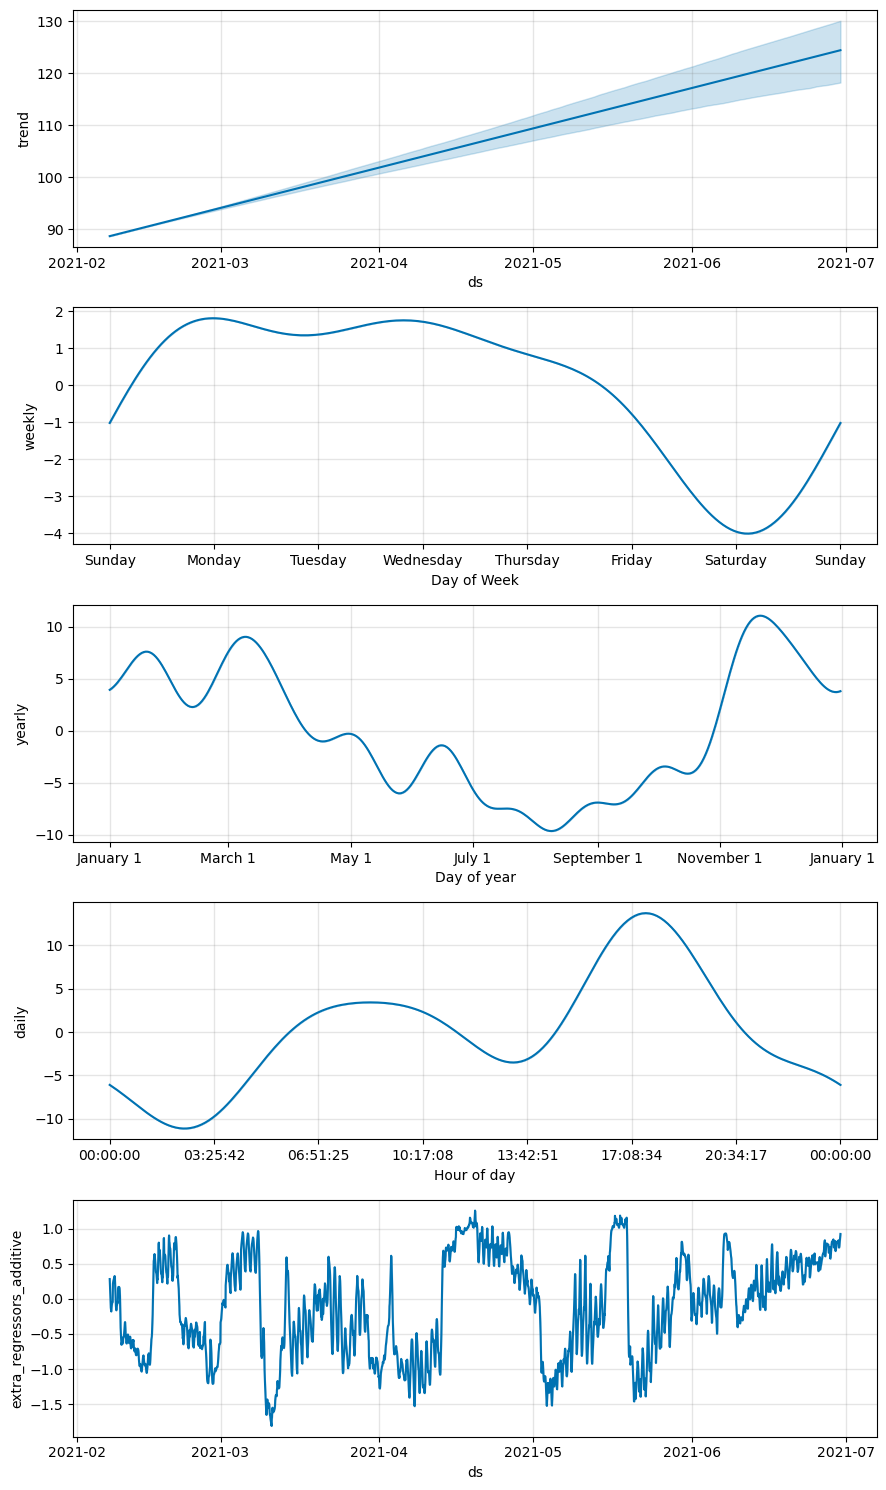

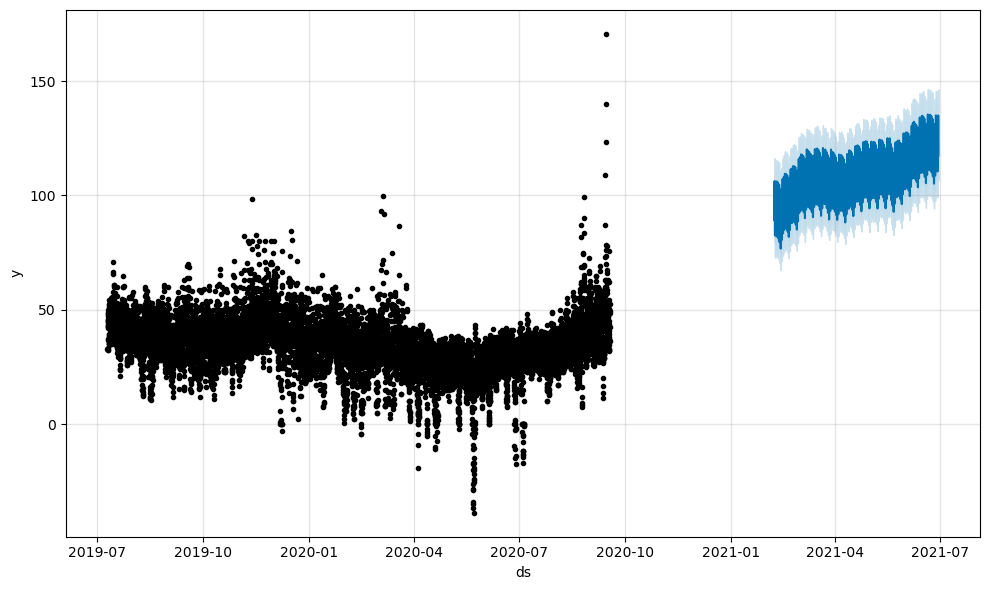

In [35]:
# Performance illustration of model using forward selection
#
# Short time series can definitely have sensitivity to the parameters, particularly the changepoint_prior_scale.
# This can significantly impact the prediction: A very small value will force a linear trend, 
# while a large value will allow the trend to fluctuate quite a bit 
# (and, if there is little data, possibly capture seasonal effects).
SELECTED_COLS_fp = Prophet(yearly_seasonality = True, changepoint_prior_scale=0.01)
#
for feature in selected_cols:
    #
    SELECTED_COLS_fp.add_regressor(feature, standardize = True)  
#
SELECTED_COLS_m = SELECTED_COLS_fp.fit(train)
#
SELECTED_COLS_test_MAE, SELECTED_COLS_test_MRAE = preformance(SELECTED_COLS_m, test)
#
print("Performance using forward selection algorithm:")
print("MAE: ", SELECTED_COLS_test_MAE, ", MRAE: ", SELECTED_COLS_test_MRAE)
#
forecast = SELECTED_COLS_m.predict(test)
forecast = forecast.merge(test[["ds", "y"]], on = "ds")
fig1 = SELECTED_COLS_m.plot_components(forecast)
fig2 = SELECTED_COLS_m.plot(forecast)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', "y"]].tail(11))

10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:18 - cmdstanpy - INFO - Chain [1] done processing


{'val_MAE': 15.20547403349036, 'val_MRAE': 41.01250418489532, 'test_MAE': 20.070714735758926, 'test_MRAE': 17.911812652867752}


ds        yhat  yhat_lower  yhat_upper      y
3412 2021-06-29 13:00:00   94.367190   87.777300  101.971822   79.5
3413 2021-06-29 14:00:00   95.153277   87.936723  102.502343   81.0
3414 2021-06-29 15:00:00  103.501266   95.375377  110.841089   90.0
3415 2021-06-29 16:00:00  112.699188  105.508163  120.436447  100.9
3416 2021-06-29 17:00:00  116.339691  108.951698  124.014967  102.0
3417 2021-06-29 18:00:00  114.834925  107.367498  122.597295   97.9
3418 2021-06-29 19:00:00  106.430002   98.798484  114.159081   87.0
3419 2021-06-29 20:00:00  102.136248   94.784154  109.402997   85.0
3420 2021-06-29 21:00:00   97.990747   90.370889  105.936597   80.1
3421 2021-06-29 22:00:00  100.493082   92.921828  108.215053   82.5
3422 2021-06-29 23:00:00   96.471290   88.959666  104.071403   77.5

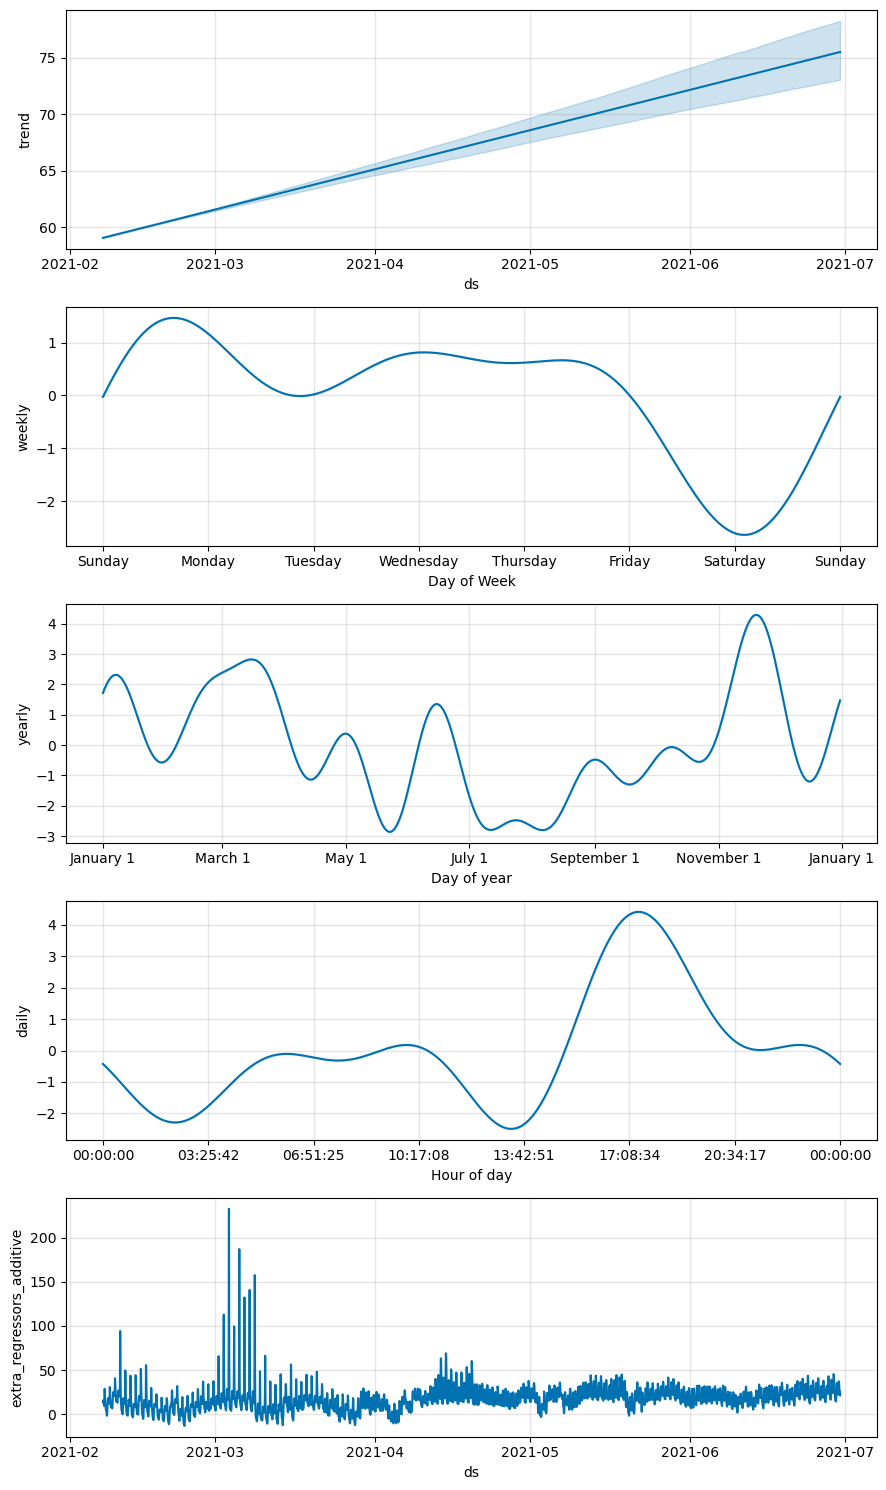

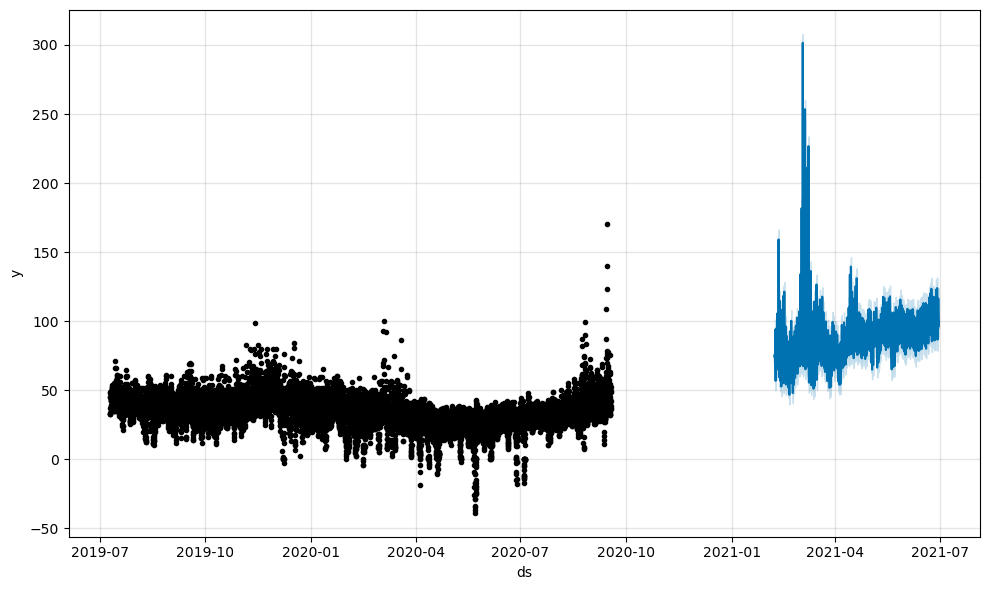

In [36]:
# USE ALL features for Facebook Prophet
# Short time series can definitely have sensitivity to the parameters, particularly the changepoint_prior_scale.
# This can significantly impact the prediction: A very small value will force a linear trend, 
# while a large value will allow the trend to fluctuate quite a bit 
# (and, if there is little data, possibly capture seasonal effects).
ALL_fp = Prophet(yearly_seasonality = True, changepoint_prior_scale=0.01)
#
for feature in train_cols:
    #
    ALL_fp.add_regressor(feature, standardize = True)  
#
ALL_m = ALL_fp.fit(train)
#
ALL_val_MAE,  ALL_val_MRAE  = preformance(ALL_m, val)
ALL_test_MAE, ALL_test_MRAE = preformance(ALL_m, test)
#
elem = {"val_MAE": ALL_val_MAE, "val_MRAE": ALL_val_MRAE, "test_MAE": ALL_test_MAE, "test_MRAE": ALL_test_MRAE}
print(elem)
forecast = ALL_m.predict(test)
forecast = forecast.merge(test[["ds", "y"]], on = "ds")
fig1 = ALL_m.plot_components(forecast)
fig2 = ALL_m.plot(forecast)
#a = add_changepoints_to_plot(fig2.gca(), ALL_fp, forecast)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', "y"]].tail(11))

In [40]:
# if "GP_prediction.csv" exists then we just load results of Gaussian Processes forecast 
# otherwise we compute forecast using Gaussian Processes
# Gaussian Processes in sliding windows
# we use the following features: 
# ['previous_price_gbp_ORDER_5', 'previous_price_gbp_ORDER_4',
#  'previous_price_gbp_ORDER_3', 'previous_price_gbp_ORDER_2',
#  'previous_price_gbp_ORDER_1', 'previous_price_gbp_ORDER_0', 
#  'season', 'Hour']
#
# We have not use any feture selection algorithm here.
#
#
path_to_file = "GP_prediction.csv"
#
if os.path.exists(path_to_file):
   print("Read results of GP prediction") 
   final_df = pd.read_csv(path_to_file, index_col = 0)
else:
  #  
  kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
                     noise_level=1, noise_level_bounds=(1e-5, 2e1) )
  #
  gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
  #
  data = sub_forecast_wind_mw.copy()
  #
  window_size = 11
  Hours = data["Hour"].unique()
  #
  final_df =pd.DataFrame()
  #
  data["recommended price"] = np.nan    
  data["std"] = np.nan    
  #    
  for Hour in Hours:
    print("Hour: ", Hour)
    hour_data = data[data["Hour"] == Hour].copy()
    #
    hour_data.sort_values(by = "ds", inplace = True) 
    # 
    hour_data.index = list(range(len(hour_data)))
    index = list(range(len(hour_data)))
    #
    start = time()
    #
    for i in range(window_size, len(hour_data)):
        # get previous 10 month prices
        X_train = hour_data.loc[index[i-window_size: i], :].copy()
        #
        if 1 :
           GP_train_cols = ['previous_price_gbp_ORDER_5', 'previous_price_gbp_ORDER_4',
                            'previous_price_gbp_ORDER_3', 'previous_price_gbp_ORDER_2',
                            'previous_price_gbp_ORDER_1', 'previous_price_gbp_ORDER_0']#, 
                            #'season', 'Hour']#, 'forecast_wind_mw_ORDER_4', 'forecast_wind_mw_std']
        else:
           GP_train_cols = train_cols.copy() 
        #
        y_train = X_train["y"].values.copy()
        X_train = X_train[GP_train_cols].values.copy()
        #
        gpr.fit(X_train, y_train)
        #
        X_test = hour_data.loc[index[i], :].copy()
        X_test = X_test[GP_train_cols].values.copy()
        #
        y_mean, y_std = gpr.predict([X_test], return_std=True)
        #print(y_mean)
        #
        hour_data.loc[index[i], "recommended price"] = y_mean[0]
        hour_data.loc[index[i], "std"              ] = y_std[0]
    #
    final_df = final_df.append(hour_data)
    #
    end = time()
    #
    print("Computation of GP prediction for Hour ", Hour, " took ", np.round(end - start, 2), " seconds")
    print("Save results for Hour ", Hour, " forecast using GP", ", i: ", i)
    #
    final_df.to_csv(path_to_file)     
#
print("OK")

Read results of GP prediction
OK


In [41]:
final_df = final_df[train_cols + ['ds', 'y', "recommended price", "std"]]
final_df

forecast_wind_mw_median  forecast_wind_mw_std  forecast_wind_mw_Q25  \
0                     1341.5           1175.933908               1172.00   
1                     1341.5            434.415092               1172.00   
2                     1405.5            846.416564               1202.75   
3                     1627.0            837.170516               1204.00   
4                     1627.0            735.722642               1341.25   
..                       ...                   ...                   ...   
717                   2668.0           1570.152187               1662.00   
718                   2635.0           1242.549395               1662.00   
719                   2309.0           1304.680729               1484.75   
720                   3015.5           1091.011266               1852.25   
721                   2615.0            713.924230               1703.75   

     forecast_wind_mw_Q75  forecast_wind_mw_max  forecast_wind_mw_ORDER_5  \
0                 1406.75                4282.0                    4282.0   
1                 1406.75                2173.0                    1280.0   
2                 1981.75                3319.0                    1403.0   
3                 2091.25                3319.0                     719.0   
4                 2091.25                3319.0                    1136.0   
..                    ...                   ...                       ...   
717               4288.25                5127.0                    5127.0   
718               3168.50                4656.0                    2151.0   
719               3168.50                4656.0                     864.0   
720               3168.50                4656.0                    4656.0   
721               3067.25                3185.0                    3185.0   

     forecast_wind_mw_ORDER_4  forecast_wind_mw_ORDER_3  \
0                      1280.0                    1403.0   
1                      1403.0                     719.0   
2                       719.0                    1136.0   
3                      1136.0                    1408.0   
4                      1408.0                    2173.0   
..                        ...                       ...   
717                    2151.0                     864.0   
718                     864.0                    4656.0   
719                    4656.0                    3185.0   
720                    3185.0                    1499.0   
721                    1499.0                    3119.0   

     forecast_wind_mw_ORDER_2  forecast_wind_mw_ORDER_1  ...  \
0                       719.0                    1136.0  ...   
1                      1136.0                    1408.0  ...   
2                      1408.0                    2173.0  ...   
3                      2173.0                    3319.0  ...   
4                      3319.0                    1846.0  ...   
..                        ...                       ...  ...   
717                    4656.0                    3185.0  ...   
718                    3185.0                    1499.0  ...   
719                    1499.0                    3119.0  ...   
720                    3119.0                    1480.0  ...   
721                    1480.0                    2912.0  ...   

     previous_price_gbp_ORDER_3  previous_price_gbp_ORDER_2  \
0                         34.00                       32.00   
1                         32.00                       33.07   
2                         33.07                       35.20   
3                         35.20                       32.94   
4                         32.94                       38.41   
..                          ...                         ...   
717                       75.00                       75.00   
718                       75.00                       71.10   
719                       71.10                       85.00   
720                       85.00                       81.00

In [52]:
wo_na_final_df["ds"]
#val[["ds"]]

11     2019-07-21 00:00:00
12     2019-07-22 00:00:00
13     2019-07-23 00:00:00
14     2019-07-24 00:00:00
15     2019-07-25 00:00:00
              ...         
717    2021-06-25 23:00:00
718    2021-06-26 23:00:00
719    2021-06-27 23:00:00
720    2021-06-28 23:00:00
721    2021-06-29 23:00:00
Name: ds, Length: 17064, dtype: object

In [55]:
wo_na_final_df = final_df.dropna()
wo_na_final_df["ds"] = pd.to_datetime(wo_na_final_df["ds"]) 
#
wo_na_final_df.sort_values(by = "ds", inplace = True)
#
wo_na_final_df["MAE" ] = wo_na_final_df.apply(lambda x: np.abs(x["y"] - x["recommended price"]), axis = 1)
wo_na_final_df["MRAE"] = wo_na_final_df.apply(lambda x: np.abs((x["y"] - x["recommended price"]) * 100 / x["y"]) if x["y"] != 0.0 else np.abs(x["y"] - x["recommended price"]), axis = 1)
#
val_wo_na_final_df  = wo_na_final_df.merge( val[["ds"]], on = "ds")
test_wo_na_final_df = wo_na_final_df.merge(test[["ds"]], on = "ds")
print("Validation, MAE: " , val_wo_na_final_df[ "MAE"].mean(), ", MRAE: ", val_wo_na_final_df[ "MRAE"].mean())
print("Test,       MAE: " , test_wo_na_final_df["MAE"].mean(), ", MRAE: ", test_wo_na_final_df["MRAE"].mean())

Validation, MAE:  18.858925309401585 , MRAE:  116.55764304487768
Test,       MAE:  13.679647775385533 , MRAE:  22.91250185541275


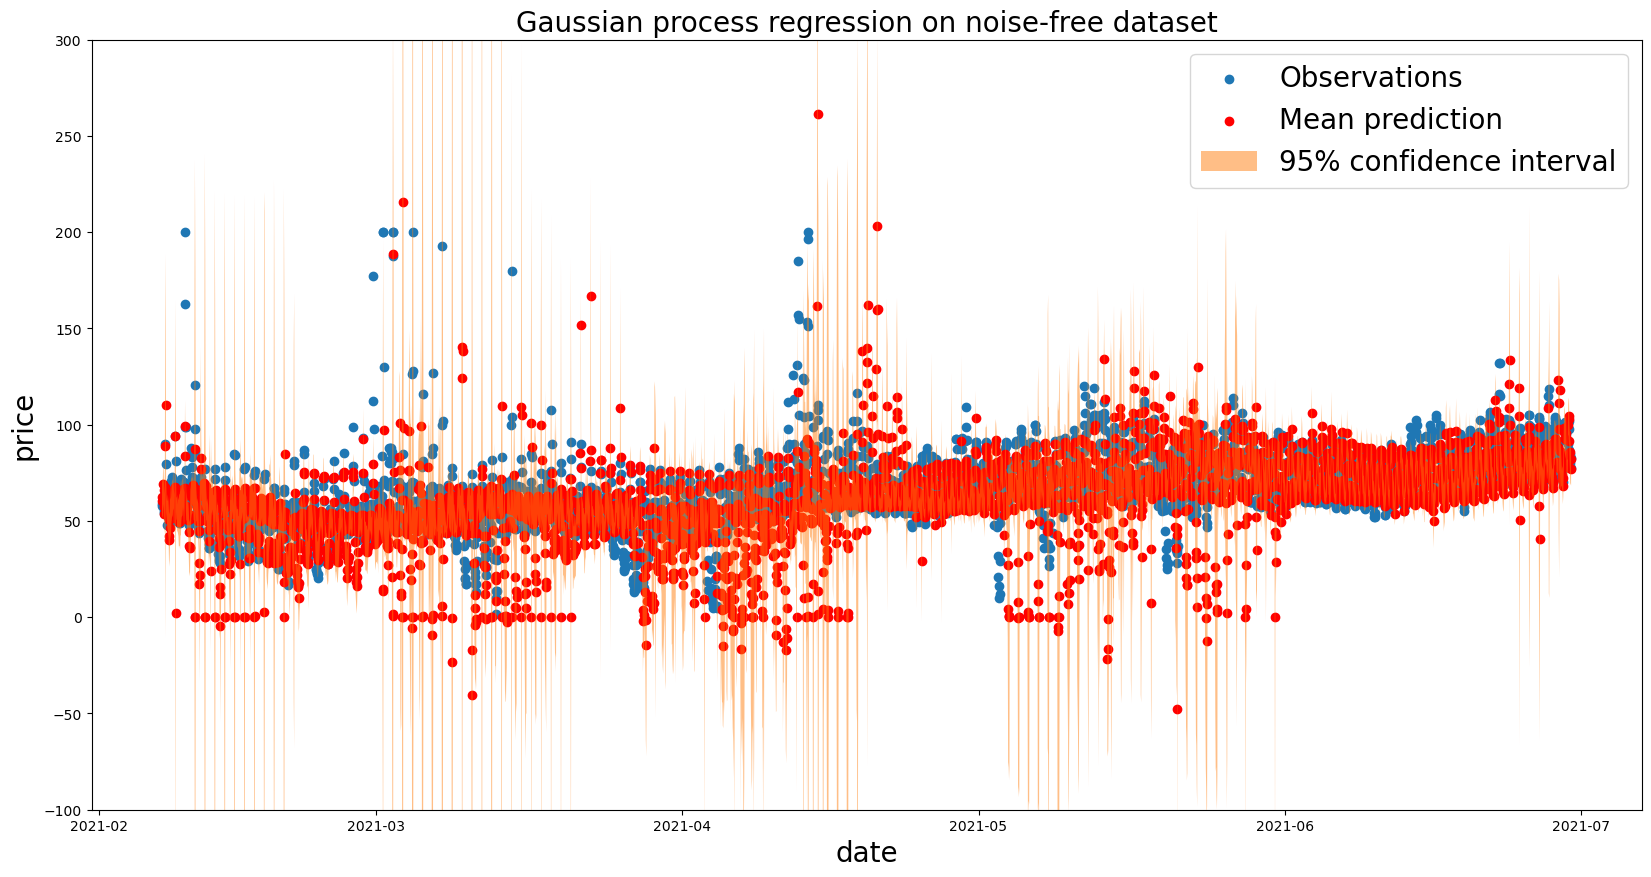

In [56]:
plt.rcParams["figure.figsize"] = (20,10)
X = test_wo_na_final_df["ds"].values.copy()
y = test_wo_na_final_df["y"].values.copy() 
#
mean_prediction = test_wo_na_final_df["recommended price"].values.copy()
std_prediction  = test_wo_na_final_df["std"].values.copy()

y[y > 200] = 200
#plt.plot(X, y, label= "Observations", linestyle="dotted", color='C0')
plt.scatter(X, y, label="Observations")
plt.scatter(X, mean_prediction, label="Mean prediction", color = "r")
#plt.plot(X, mean_prediction, label="Mean prediction", color = "r")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.ylim([-100, 300])
plt.legend(fontsize=20)
plt.xlabel("date", fontsize=20)
plt.ylabel("price", fontsize=20)
_ = plt.title("Gaussian process regression on noise-free dataset", fontsize = 20)

In [57]:
# 
val_wo_na_final_df.to_csv("GP_val_wo_na_final_df.csv")
val_wo_na_final_df.groupby("Hour").agg({"MAE": "mean", "MRAE": "mean"}).reset_index()

Hour         MAE        MRAE
0      0   12.442041  339.809421
1      1   12.663141  480.792507
2      2   11.423048  501.028140
3      3   11.191480   80.989733
4      4   11.980900  239.166093
5      5   12.367008  610.952219
6      6   14.329066   49.217744
7      7   13.131210   37.804175
8      8   14.424659   28.213155
9      9   16.599124   27.159708
10    10   15.058603   23.497624
11    11   15.168621   22.751192
12    12   16.401588   22.835774
13    13   12.822371   18.356527
14    14   12.453352   20.126691
15    15   10.979319   19.031365
16    16   46.641853   45.870408
17    17  100.984227   64.690520
18    18   50.393145   48.132011
19    19   12.947676   18.090658
20    20    4.339734    8.185578
21    21    5.046266   12.195851
22    22    6.618763   18.900115
23    23   12.968640   53.620318

In [58]:
test_wo_na_final_df.to_csv("GP_test_wo_na_final_df.csv")
test_wo_na_final_df.groupby("Hour").agg({"MAE": "mean", "MRAE": "mean"}).reset_index()

Hour        MAE       MRAE
0      0  13.830800  29.104980
1      1  14.343886  33.553160
2      2  15.174900  39.037609
3      3  16.150125  43.769462
4      4  13.105855  34.147988
5      5  14.756555  29.250654
6      6  17.424252  30.049006
7      7  16.471812  26.065332
8      8  11.316870  16.825274
9      9   9.540715  15.249746
10    10   9.020645  13.607012
11    11  10.083258  15.039969
12    12   9.572743  17.180898
13    13   8.526698  17.419857
14    14   8.927159  18.101845
15    15   8.551707  13.885046
16    16  11.358209  14.754240
17    17  28.926405  29.956835
18    18  41.609121  35.772942
19    19  17.187011  20.130447
20    20   7.678297  10.963685
21    21   6.084854  10.185792
22    22   8.263290  14.590647
23    23  10.472522  21.786226

In [59]:
start = time()
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
                   noise_level=1, noise_level_bounds=(1e-5, 2e1) )
#
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
#    
GP_train_cols = ['previous_price_gbp_ORDER_5', 'previous_price_gbp_ORDER_4',
                 'previous_price_gbp_ORDER_3', 'previous_price_gbp_ORDER_2',
                 'previous_price_gbp_ORDER_1', 'previous_price_gbp_ORDER_0', 
                 'season', 'Hour']
#
sub_train = train.sample(n = 1000, replace = False, random_state = 1)
X_train = sub_train[GP_train_cols].values.copy()
y_train = sub_train["y"].values.copy()
#
gpr.fit(X_train, y_train)
#
X_test = test[GP_train_cols].values.copy()

y_mean, y_std = gpr.predict(X_test, return_std=True)
#
end = time()
print("Computation time  is ", end - start)

Computation time  is  5.799045085906982


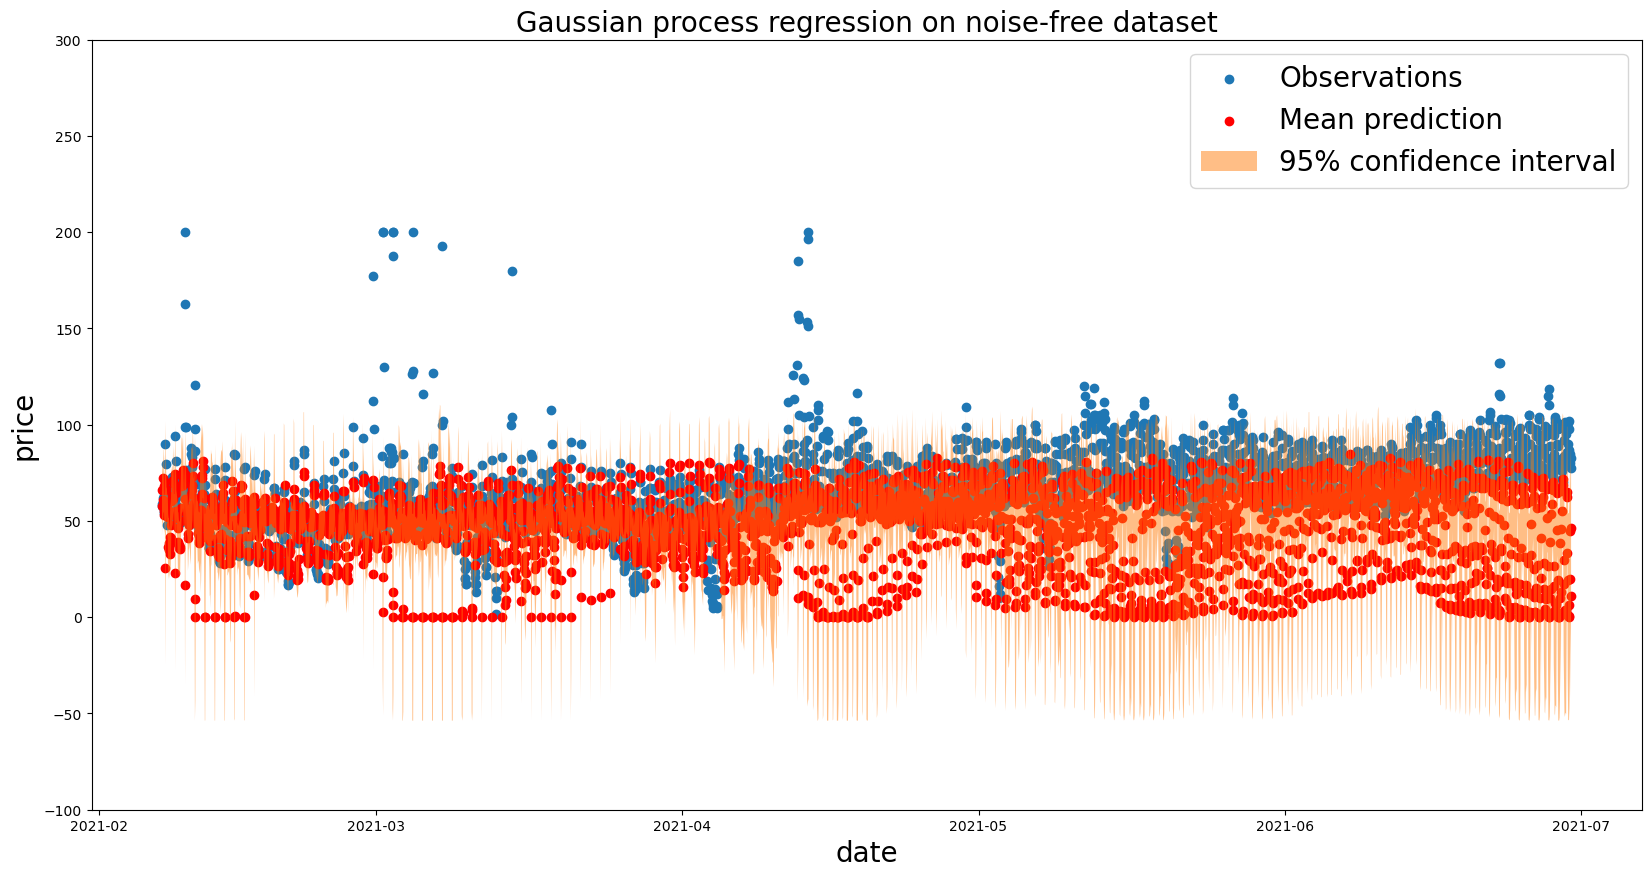

In [60]:
plt.rcParams["figure.figsize"] = (20, 10)
X = test["ds"].values.copy()
y = test["y"].values.copy() 
#
mean_prediction = y_mean.copy()
std_prediction  = y_std.copy()

y[y > 200] = 200
#
plt.scatter(X, y, label="Observations")
plt.scatter(X, mean_prediction, label="Mean prediction", color = "r")
#plt.plot(X, mean_prediction, label="Mean prediction", color = "r")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.ylim([-100, 300])
plt.legend(fontsize=20)
plt.xlabel("date", fontsize=20)
plt.ylabel("price", fontsize=20)
_ = plt.title("Gaussian process regression on noise-free dataset", fontsize = 20)

In [61]:
y = test["y"].values
MAE = np.mean( np.abs(y_mean - y) )
MRAE = np.mean( np.abs( (y_mean - y) * 100/ y) )
print("MAE: ", MAE, "MRAE: ", MRAE)

MAE:  24.326277079134815 MRAE:  34.15153759822349


In [62]:
len(train)

10483